# Import Statements

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotnine as plt2
from plotnine import aes, ggplot
import math
from tqdm import tqdm
import scipy.stats as stats
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from skprog.wrappers import TreesProgressor

from utility import VariableInfo as var_info
from utility import Overview as ovr
from utility import Vizualisations as viz

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Best performing model with Interpretation

## Data import

In [2]:
train_df = pd.read_csv(r".\Dataset\SmoteNC\SmoteNC_X.csv", low_memory = False)
X_validate = pd.read_csv(r".\Dataset\SmoteNC\X_val.csv", low_memory = False)
Y_val = pd.read_csv(r".\Dataset\SmoteNC\Y_val.csv", low_memory = False)
test_df = pd.read_csv(r".\Dataset\FinalData\test_data.csv", low_memory = False)

In [3]:
train_df = train_df.astype({"verification_status":"category", \
                "loan_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category"})

X_validate = X_validate.astype({"verification_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category"})

test_df = test_df.astype({"verification_status":"category", \
                "loan_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category", \
                "earliest_cr_line":"datetime64[ns]", \
                "issue_d":"datetime64[ns]", \
                "last_credit_pull_d":"datetime64[ns]"})

In [4]:
train_df = train_df.astype({"emp_length":"object"})
train_df["emp_length"].fillna("NA", inplace=True)
train_df = train_df.astype({"emp_length":"category"})

X_validate = X_validate.astype({"emp_length":"object"})
X_validate["emp_length"].fillna("NA", inplace=True)
X_validate = X_validate.astype({"emp_length":"category"})

test_df = test_df.astype({"emp_length":"object"})
test_df["emp_length"].fillna("NA", inplace=True)
test_df = test_df.astype({"emp_length":"category"})

In [5]:
num_cols = list(train_df.select_dtypes(include=["int64", "float64"]).columns)

cat_cols = list(train_df.select_dtypes(include=["category"]).columns)
cat_cols.remove("loan_status")

X_train = train_df[num_cols + cat_cols]
Y_tr = train_df["loan_status"]

default_value = None
encoding_dict = dict.fromkeys(cat_cols, default_value)

X_tr = X_train[num_cols].to_numpy()
X_val = X_validate[num_cols].to_numpy()

for key, value in encoding_dict.items():
    if value == None:
        encoding_dict[key] = LabelBinarizer()
        encoding_dict[key].fit(X_train[key].values.reshape(-1, 1))
        X_tr = np.concatenate((X_tr, encoding_dict[key].transform(X_train[key].values.reshape(-1, 1))), axis = 1)
        X_val = np.concatenate((X_val, encoding_dict[key].transform(X_validate[key].values.reshape(-1, 1))), axis=1)

In [6]:
feature_names = []
for k, v in encoding_dict.items():
    feature_names.extend(v.classes_)

## Modelling

### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_smote = RandomForestClassifier(verbose=True)
rf_smote.fit(X_tr, Y_tr)
y_pred_rf_smote = rf_smote.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


In [8]:
accuracy = accuracy_score(Y_val, y_pred_rf_smote)    
f1 = f1_score(Y_val, y_pred_rf_smote, average="weighted")
precision = precision_score(Y_val, y_pred_rf_smote, average="weighted")
recall = recall_score(Y_val, y_pred_rf_smote, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.951718446883053
F1 Score: 0.9501553943667496
Precision: 0.9528270764021104
Recall: 0.951718446883053


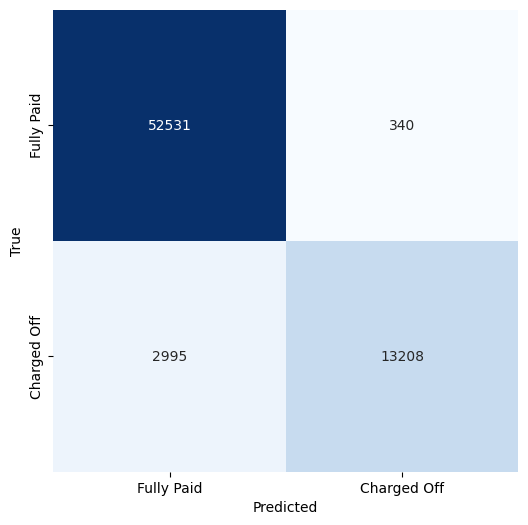

In [9]:
cm = confusion_matrix(Y_val, y_pred_rf_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


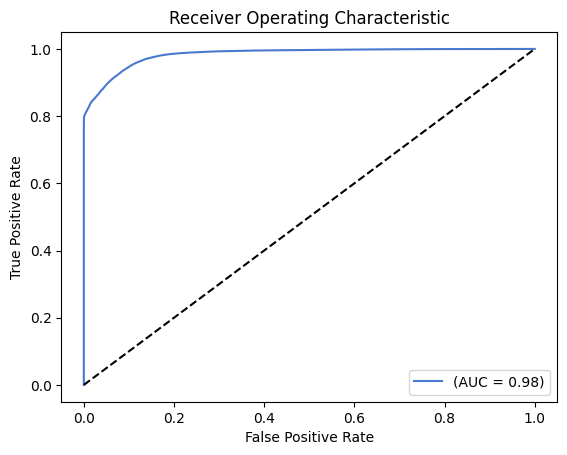

In [10]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rf_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

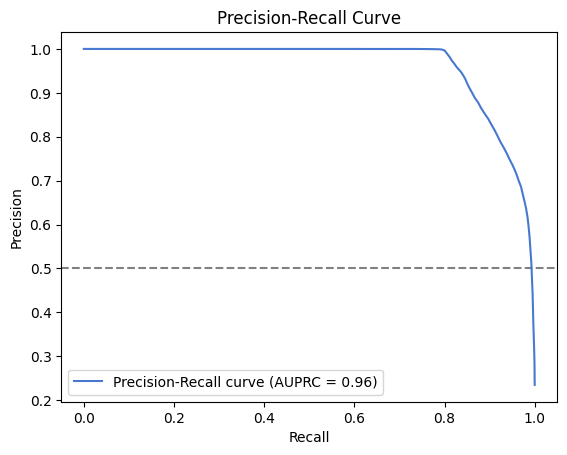

AUPRC: 0.9624109847681697


In [11]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

## Model Interpretation

In [12]:
num_cols = list(train_df.select_dtypes(include=["int64", "float64"]).columns)

In [13]:
feature_names = num_cols
for k, v in encoding_dict.items():
    feature_names.extend(v.classes_)

In [14]:
feature_names.remove("Not Verified") # Removing this column as the category Verification status is binary encoded with one column having value 0 (Not verified) and 1 (Verified)

In [15]:
validation_set = pd.DataFrame(X_val, columns = feature_names)
validation_set = validation_set.iloc[:2,:] # Interpreting 2 values from validation set
validation_set.shape

(2, 129)

In [16]:
import shap
explainer = shap.Explainer(rf_smote)
shap_values = explainer.shap_values(validation_set)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [17]:
rf_smote.predict([validation_set.iloc[0]])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([1], dtype=int64)

### Interpretation of Charged off data point

In [18]:
shap_user = shap_values[0][0,:]
shap_user_importance = np.argsort(shap_user)
top_user_n = 3
neg_cols = [feature_names[shap_user_importance[i]] for i in range(top_user_n)]
neg_vals = [shap_user[shap_user_importance[i]] for i in range(top_user_n)]
neg_indexes = [shap_user_importance[i] for i in range(top_user_n)]

pos_cols = [feature_names[shap_user_importance[-(i+1)]] for i in range(top_user_n)]
pos_vals = [shap_user[shap_user_importance[-(i+1)]] for i in range(top_user_n)]
pos_indexes = [shap_user_importance[-(i+1)] for i in range(top_user_n)]

print(neg_cols, neg_vals, neg_indexes)
print(pos_cols, pos_vals, pos_indexes)

['total_rev_hi_lim', 'dti', 'delinq_2yrs'] [-0.02970926153983048, -0.02881603151646793, -0.026396430798863595] [14, 2, 3]
['num_tl_op_past_12m', 'acc_open_past_24mths', 'num_actv_bc_tl'] [0.025305921120391463, 0.020439653253210947, 0.013879436880453403] [41, 15, 29]


In [19]:
main_feats = neg_indexes[:]
main_feats.extend(pos_indexes[:])
main_col_names = [feature_names[i] for i in main_feats]

In [20]:
# Plot the SHAP values for the selected instance
shap.initjs()  # Initialize JS visualization (for Jupyter Notebook or web-based environments)
shap.plots.force(explainer.expected_value[1], shap_values[0][0, main_feats], feature_names = main_col_names)
#shap.force_plot(explainer.expected_value[0], shap_values[0, :], X_val[0])

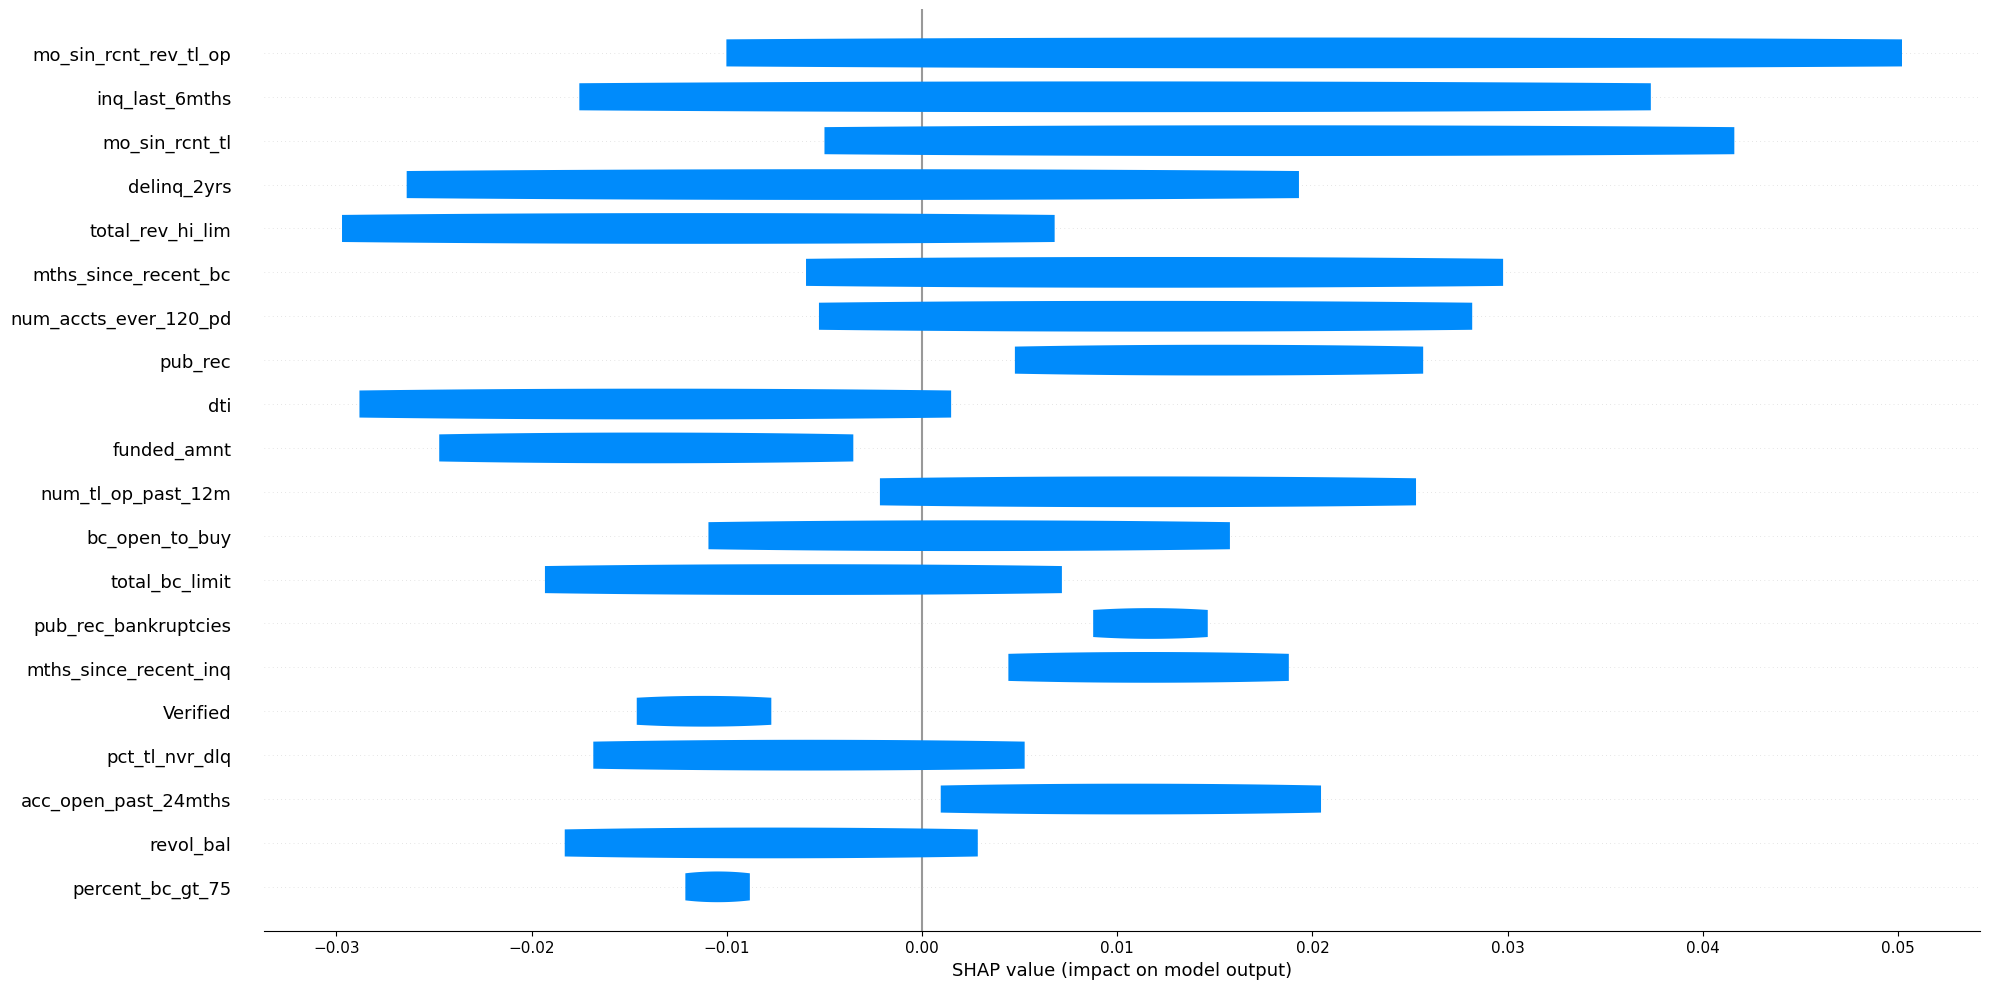

In [21]:
shap.summary_plot(shap_values[0], feature_names=feature_names, plot_type = 'violin', plot_size = (20, 10),\
                  layered_violin_max_num_bins = 80, axis_color='#000000')

### Interpretation of Fully paid data point

In [22]:
shap_user = shap_values[1][0,:]
shap_user_importance = np.argsort(shap_user)
top_user_n = 3
neg_cols = [feature_names[shap_user_importance[i]] for i in range(top_user_n)]
neg_vals = [shap_user[shap_user_importance[i]] for i in range(top_user_n)]
neg_indexes = [shap_user_importance[i] for i in range(top_user_n)]

pos_cols = [feature_names[shap_user_importance[-(i+1)]] for i in range(top_user_n)]
pos_vals = [shap_user[shap_user_importance[-(i+1)]] for i in range(top_user_n)]
pos_indexes = [shap_user_importance[-(i+1)] for i in range(top_user_n)]

print(neg_cols, neg_vals, neg_indexes)
print(pos_cols, pos_vals, pos_indexes)

['num_tl_op_past_12m', 'acc_open_past_24mths', 'num_actv_bc_tl'] [-0.025305921120351068, -0.02043965325317493, -0.013879436880536092] [41, 15, 29]
['total_rev_hi_lim', 'dti', 'delinq_2yrs'] [0.029709261539772953, 0.02881603151648773, 0.026396430798856268] [14, 2, 3]


In [23]:
main_feats = neg_indexes[:]
main_feats.extend(pos_indexes[:])
main_col_names = [feature_names[i] for i in main_feats]

In [24]:
# Plot the SHAP values for the selected instance
shap.initjs()  # Initialize JS visualization (for Jupyter Notebook or web-based environments)
shap.plots.force(explainer.expected_value[1], shap_values[1][0, main_feats], feature_names = main_col_names)
#shap.force_plot(explainer.expected_value[0], shap_values[0, :], X_val[0])

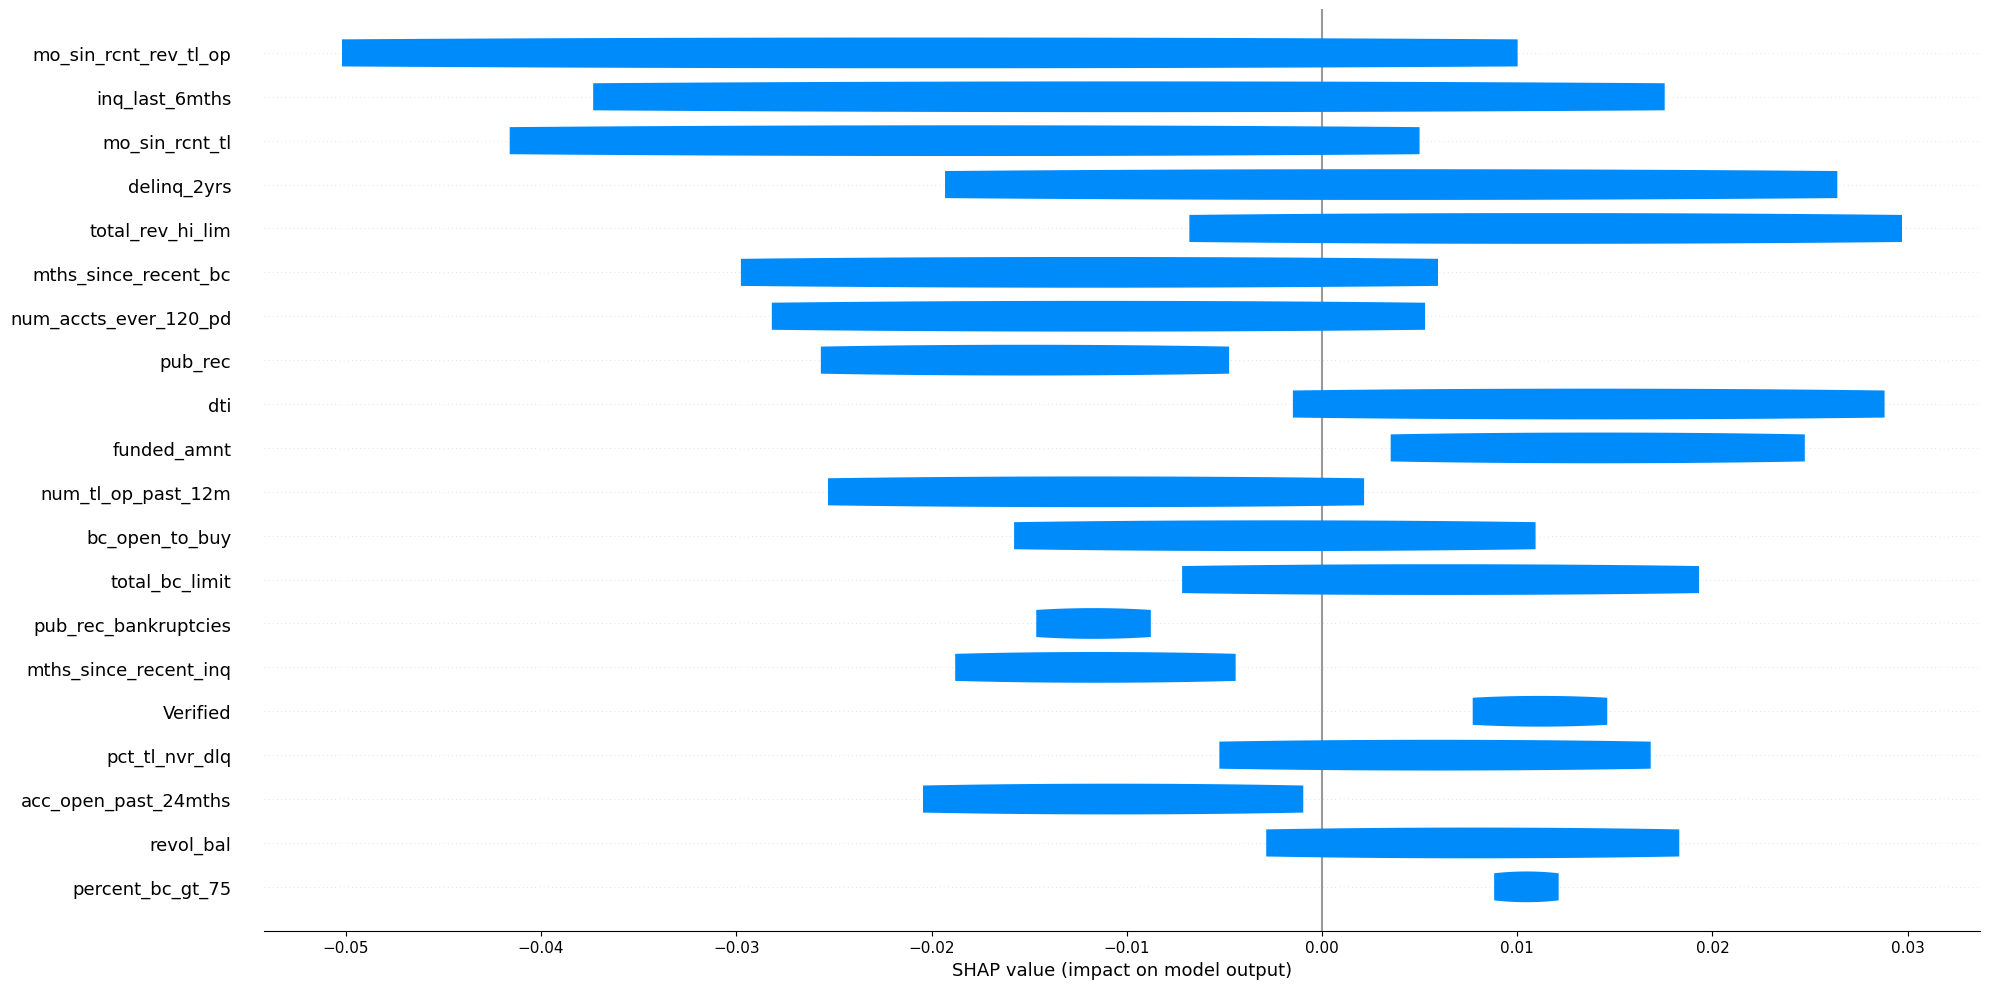

In [25]:
shap.summary_plot(shap_values[1], feature_names=feature_names, plot_type = 'violin', plot_size = (20, 10),\
                  layered_violin_max_num_bins = 80, axis_color='#000000')

# Without oversampling

## Data Import

In [26]:
train_df = pd.read_csv(r".\Dataset\FinalData\train_data.csv", low_memory = False)
test_df = pd.read_csv(r".\Dataset\FinalData\test_data.csv", low_memory = False)

In [27]:
train_df = train_df.astype({"verification_status":"category", \
                "loan_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category", \
                "earliest_cr_line":"datetime64[ns]", \
                "issue_d":"datetime64[ns]", \
                "last_credit_pull_d":"datetime64[ns]"})

test_df = test_df.astype({"verification_status":"category", \
                "loan_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category", \
                "earliest_cr_line":"datetime64[ns]", \
                "issue_d":"datetime64[ns]", \
                "last_credit_pull_d":"datetime64[ns]"})

In [28]:
train_df = train_df[train_df["issue_d"].dt.year.isin([2016, 2017])]
train_df.shape

(345366, 61)

In [29]:
train_df = train_df.astype({"emp_length":"object"})
train_df["emp_length"].fillna("NA", inplace=True)
train_df = train_df.astype({"emp_length":"category"})

test_df = test_df.astype({"emp_length":"object"})
test_df["emp_length"].fillna("NA", inplace=True)
test_df = test_df.astype({"emp_length":"category"})

In [30]:
num_cols = list(train_df.select_dtypes(include=["int64", "float64"]).columns)
num_cols.remove("id")

cat_cols = list(train_df.select_dtypes(include=["category"]).columns)
cat_cols.remove("loan_status")

X_train = train_df[num_cols + cat_cols]
Y_tr = train_df["loan_status"]

X_train, X_validate, Y_tr, Y_val = train_test_split(X_train,Y_tr,test_size=0.20, stratify=Y_tr)

Y_tr = Y_tr.apply(lambda x : 1 if x == "Charged Off" else 0) # Charged Off - 1 , Fully paid - 0
Y_val = Y_val.apply(lambda x : 1 if x == "Charged Off" else 0) # Charged Off - 1 , Fully paid - 0

default_value = None
encoding_dict = dict.fromkeys(cat_cols, default_value)

X_tr = X_train[num_cols].to_numpy()
X_val = X_validate[num_cols].to_numpy()

for key, value in encoding_dict.items():
    if value == None:
        encoding_dict[key] = LabelBinarizer()
        encoding_dict[key].fit(X_train[key].values.reshape(-1, 1))
        X_tr = np.concatenate((X_tr, encoding_dict[key].transform(X_train[key].values.reshape(-1, 1))), axis = 1)
        X_val = np.concatenate((X_val, encoding_dict[key].transform(X_validate[key].values.reshape(-1, 1))), axis=1)

## Modelling

### Logistic Regression

In [31]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve
)

In [32]:
from sklearn.linear_model import LogisticRegression

logisticRegr1 = LogisticRegression(verbose=1)
logisticRegr1.fit(X_tr, Y_tr)

y_pred = logisticRegr1.predict(X_val)
accuray = accuracy_score(Y_val, y_pred)    
f1 = f1_score(Y_val, y_pred, average="weighted")

precision = precision_score(Y_val, y_pred, average="weighted")
recall = recall_score(Y_val, y_pred, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.7656715985754409
F1 Score: 0.666219644029993
Precision: 0.7162667227960484
Recall: 0.7656715985754409


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


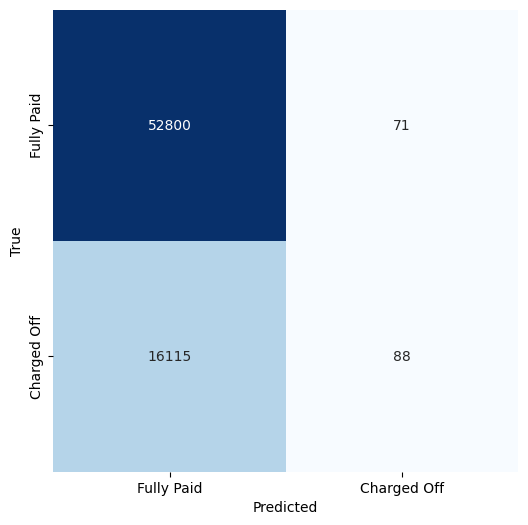

In [33]:
cm = confusion_matrix(Y_val, y_pred)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [34]:
plt.style.use('seaborn-v0_8')

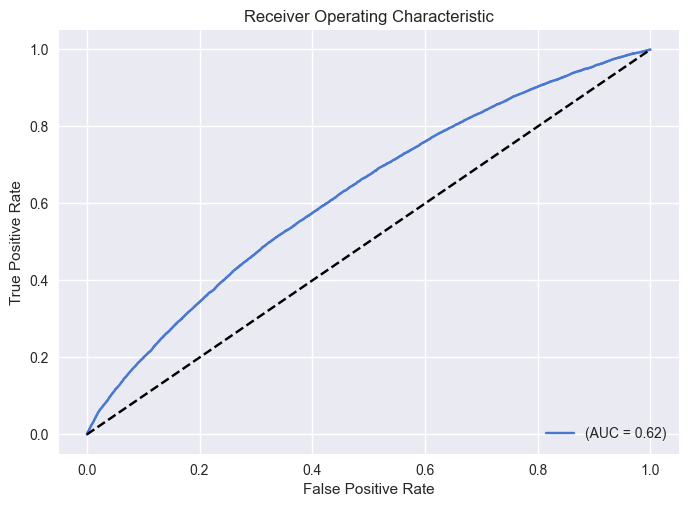

In [35]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

logistic_y_scores = logisticRegr1.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, logistic_y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

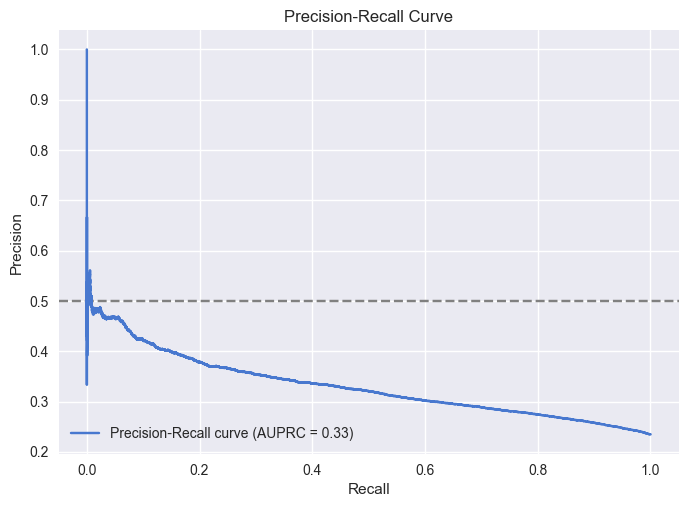

AUPRC: 0.33010275347135853


In [36]:
from sklearn.metrics import precision_recall_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, logistic_y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [38]:
# ---------- Uncomment below code to find best k value ----------

# k_values = list(range(3, 16, 2))

# mean_accuracy_scores = []

# for k in tqdm(k_values):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_tr, Y_tr, cv=5)  # 5-fold cross-validation
#     mean_accuracy_scores.append(scores.mean())

# # Find the best k value based on the highest mean accuracy
# best_k = k_values[np.argmax(mean_accuracy_scores)]
# print("Best 'k' value:", best_k)

In [39]:
# ---------- Uncomment below code to run KNN model complexity code ---------- 

# from sklearn.model_selection import train_test_split, cross_val_score

# def knn_accuracy(k_values, X_train, y_train, X_test, y_test):
#     accuracies = []
#     train_accuracies = []
#     cv_accuracies = []
#     for k in tqdm(k_values):
#         knn_model = KNeighborsClassifier(n_neighbors=k)
#         knn_model.fit(X_train, y_train)
#         y_train_pred = knn_model.predict(X_tr)
#         train_accuracy = np.mean(Y_tr == y_train_pred)
#         train_accuracies.append(train_accuracy)
        
#         # Calculate cross-validation accuracy
#         cv_accuracy = np.mean(cross_val_score(knn_model, X_tr, Y_tr, cv=cv))
#         cv_accuracies.append(cv_accuracy)
#     return train_accuracies, cv_accuracies

# # Define a range of k values to test
# k_values = list(range(3, 16, 2))

# # Get the accuracies for different k values
# train_accuracies, cv_accuracies = knn_accuracy(k_values, X_tr, Y_tr, X_val, Y_val)

# # Plot the KNN Model Complexity Curve
# plt.figure(figsize=(8, 6))
# plt.plot(k_values, train_accuracies, marker='o', label='Training Accuracy')
# plt.plot(k_values, cv_accuracies, marker='o', label='Cross-Validation Accuracy')
# plt.xlabel('k (Number of Neighbors)')
# plt.ylabel('Accuracy')
# plt.title('KNN Model Complexity Curve')
# plt.xticks(k_values)
# plt.legend()
# plt.grid()
# plt.show()

In [40]:
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_tr, Y_tr)
y_pred_knn = knn_model.predict(X_val)

In [41]:
accuray = accuracy_score(Y_val, y_pred_knn)    
f1 = f1_score(Y_val, y_pred_knn, average="weighted")
precision = precision_score(Y_val, y_pred_knn, average="weighted")
recall = recall_score(Y_val, y_pred_knn, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7571589889104439
F1 Score: 0.6828394499622212
Precision: 0.6816565547493665
Recall: 0.7571589889104439


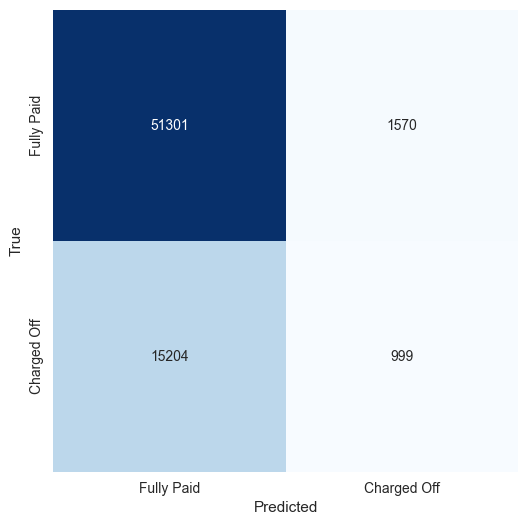

In [42]:
cm = confusion_matrix(Y_val, y_pred_knn)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

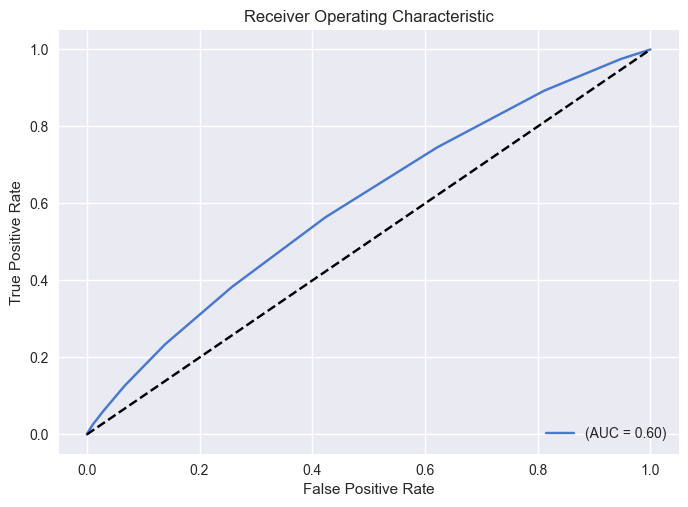

In [43]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = knn_model.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

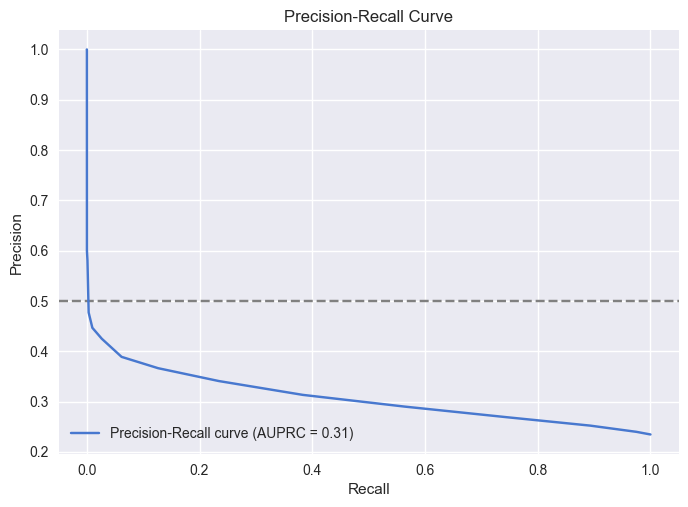

AUPRC: 0.3075249047083227


In [44]:
# Compute precision, recall, and thresholds
plt.style.use('seaborn-v0_8-muted')
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### Decision Tree

In [45]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_tr, Y_tr)
dt_y_pred = decisionTree.predict(X_val)

In [46]:
accuracy = accuracy_score(Y_val, dt_y_pred)    
f1 = f1_score(Y_val, dt_y_pred, average="weighted")
precision = precision_score(Y_val, dt_y_pred, average="weighted")
recall = recall_score(Y_val, dt_y_pred, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6636650548686915
F1 Score: 0.6674698447761895
Precision: 0.6715699375426832
Recall: 0.6636650548686915


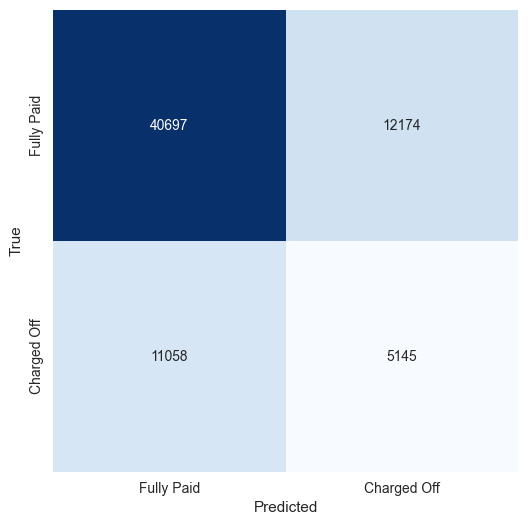

In [47]:
cm = confusion_matrix(Y_val, dt_y_pred)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

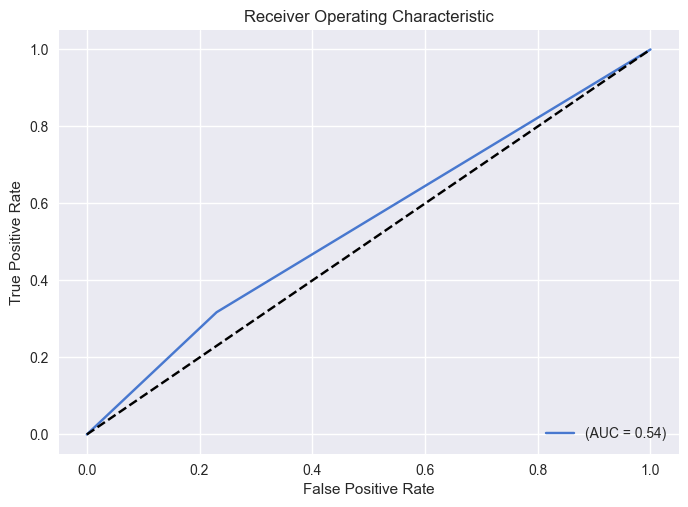

In [48]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = decisionTree.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

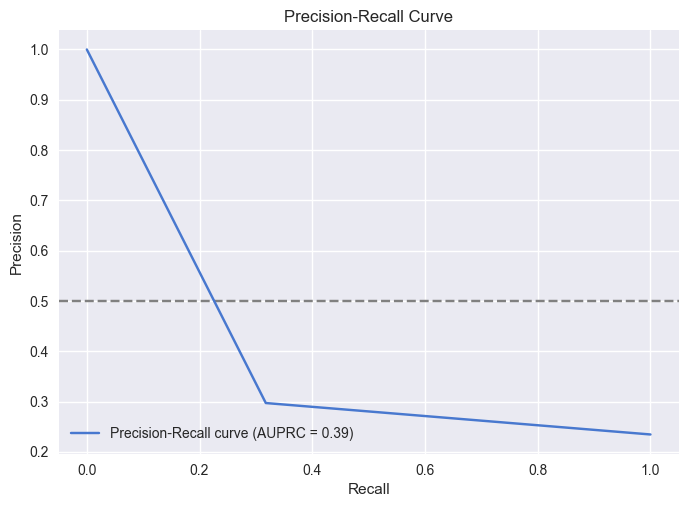

AUPRC: 0.38734777450370306


In [49]:
#Compute precision, recall, and thresholds
plt.style.use('seaborn-v0_8-muted')
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose=True)
rf.fit(X_tr, Y_tr)
y_pred_rf = rf.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


In [51]:
accuracy = accuracy_score(Y_val, y_pred_rf)    
f1 = f1_score(Y_val, y_pred_rf, average="weighted")
precision = precision_score(Y_val, y_pred_rf, average="weighted")
recall = recall_score(Y_val, y_pred_rf, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7675970698091902
F1 Score: 0.6793928598840867
Precision: 0.7247315768445111
Recall: 0.7675970698091902


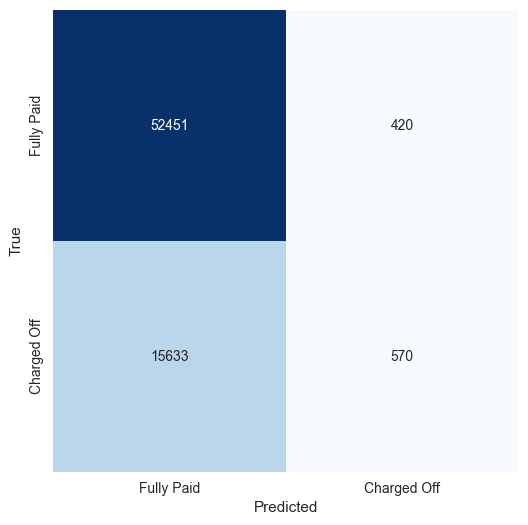

In [52]:
cm = confusion_matrix(Y_val, y_pred_rf)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


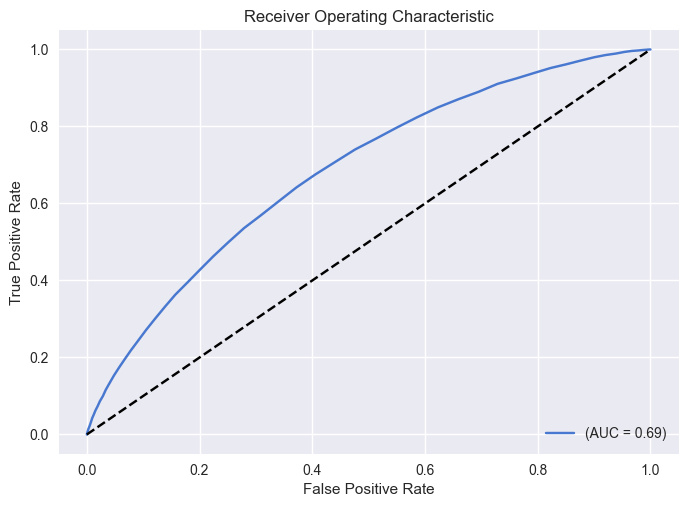

In [53]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rf.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

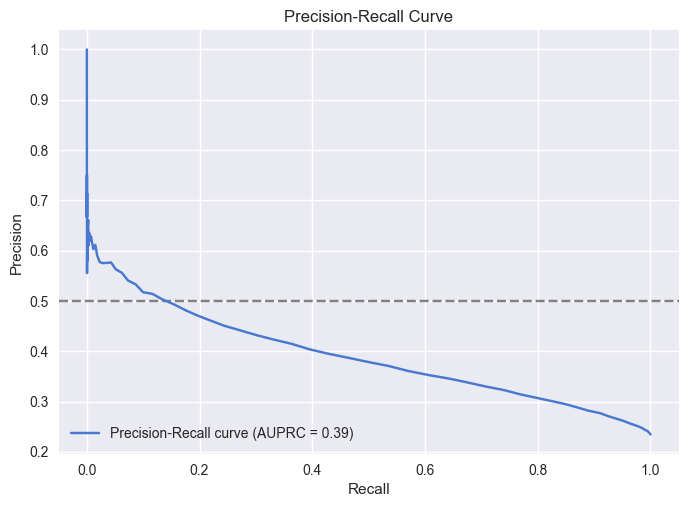

AUPRC: 0.3903958283068933


In [54]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### AdaBoost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier()
adaboost.fit(X_tr, Y_tr)
adaboost_pred = adaboost.predict(X_val)

In [56]:
accuray = accuracy_score(Y_val, adaboost_pred)    
f1 = f1_score(Y_val, adaboost_pred, average="weighted")
precision = precision_score(Y_val, adaboost_pred, average="weighted")
recall = recall_score(Y_val, adaboost_pred, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7677852737643687
F1 Score: 0.7000652267324765
Precision: 0.7196182049610784
Recall: 0.7677852737643687


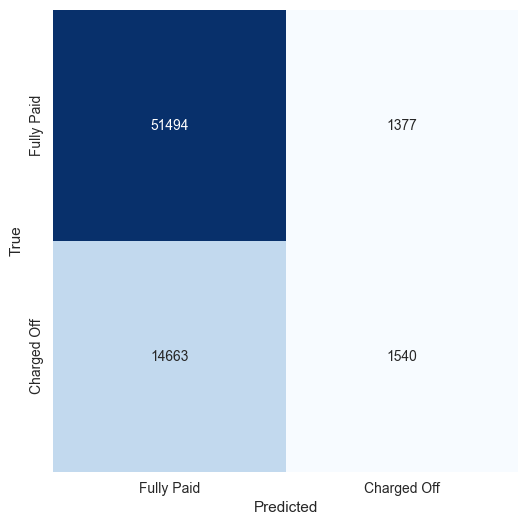

In [57]:
cm = confusion_matrix(Y_val, adaboost_pred)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

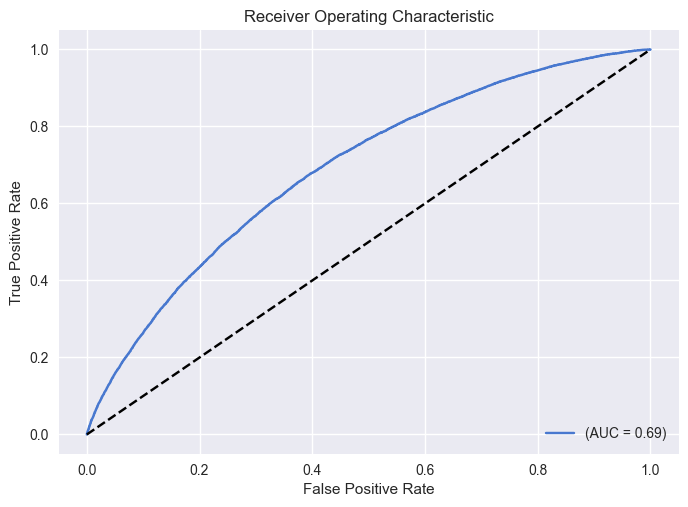

In [58]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = adaboost.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

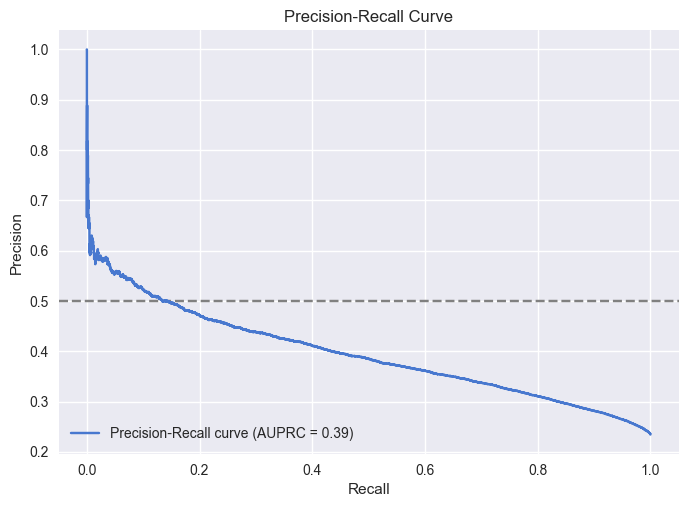

AUPRC: 0.39445795078019213


In [59]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### XGBoost

In [60]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()

# Train the model
xgb_classifier.fit(X_tr, Y_tr)
xgb_pred = xgb_classifier.predict(X_val)

In [61]:
accuray = accuracy_score(Y_val, xgb_pred)    
f1 = f1_score(Y_val, xgb_pred, average="weighted")
precision = precision_score(Y_val, xgb_pred, average="weighted")
recall = recall_score(Y_val, xgb_pred, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7690303153140111
F1 Score: 0.7117442298812258
Precision: 0.7245143179496664
Recall: 0.7690303153140111


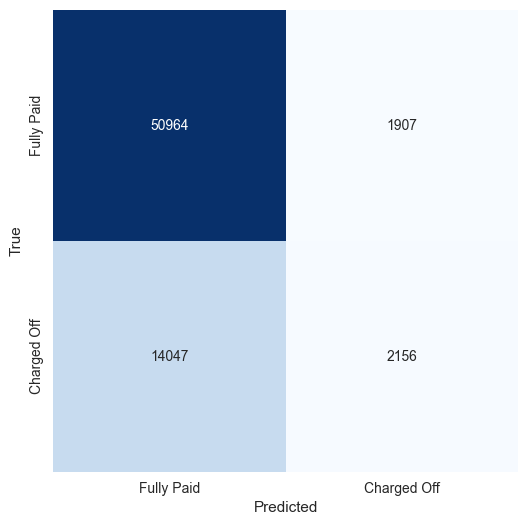

In [62]:
cm = confusion_matrix(Y_val, xgb_pred)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off", ]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

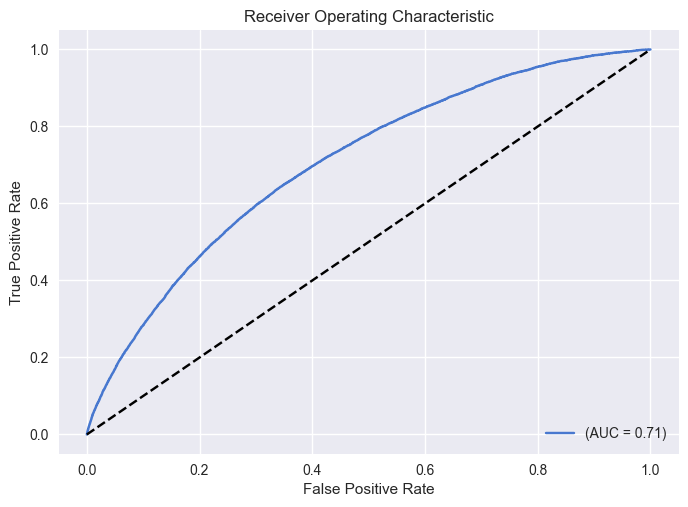

In [63]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = xgb_classifier.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

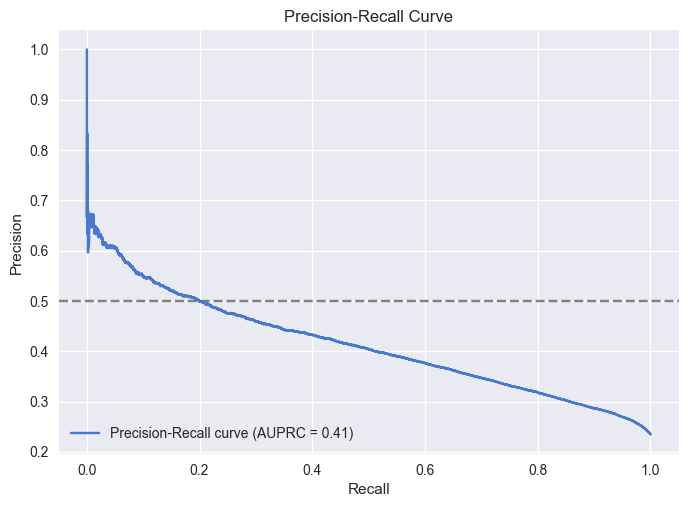

AUPRC: 0.4121453969580986


In [64]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### RUSBoost

In [65]:
from imblearn.ensemble import RUSBoostClassifier

rusboost = RUSBoostClassifier()
rusboost.fit(X_tr, Y_tr)
rusboost_pred = rusboost.predict(X_val)

In [66]:
accuray = accuracy_score(Y_val, rusboost_pred)    
f1 = f1_score(Y_val, rusboost_pred, average="weighted")
precision = precision_score(Y_val, rusboost_pred, average="weighted")
recall = recall_score(Y_val, rusboost_pred, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6314966557604887
F1 Score: 0.6590417225517022
Precision: 0.7354187321086668
Recall: 0.6314966557604887


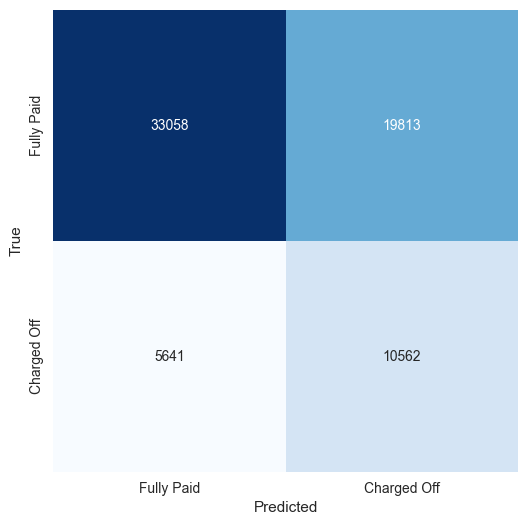

In [67]:
cm = confusion_matrix(Y_val, rusboost_pred)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

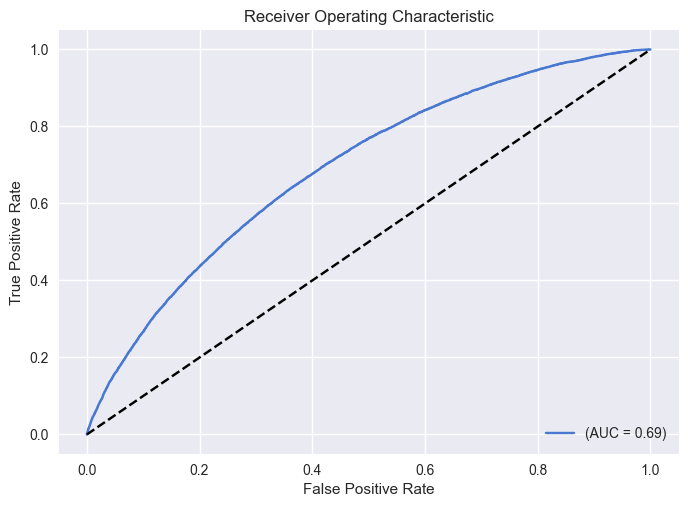

In [68]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rusboost.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

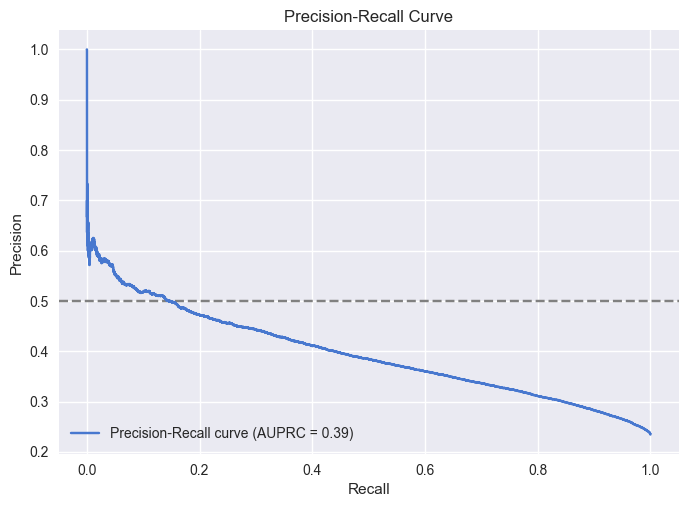

AUPRC: 0.39460242189746136


In [69]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


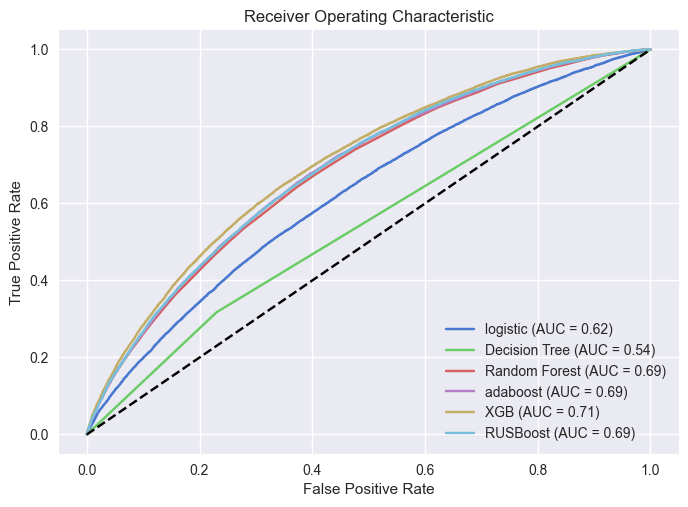

In [70]:
# Compute the FPR and TPR for each model
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

logistic_y_scores = logisticRegr1.predict_proba(X_val)[:, 1]
decisionTree_y_scores = decisionTree.predict_proba(X_val)[:, 1]
rf_y_scores = rf.predict_proba(X_val)[:, 1]
adaboost_y_scores = adaboost.predict_proba(X_val)[:, 1]
xgb_y_scores = xgb_classifier.predict_proba(X_val)[:, 1]
rusboost_y_scores = rusboost.predict_proba(X_val)[:, 1]


# Compute the false positive rate, true positive rate, and thresholds
fpr_model1, tpr_model1, _ = roc_curve(Y_val, logistic_y_scores)
fpr_model2, tpr_model2, _ = roc_curve(Y_val, rf_y_scores)
fpr_model3, tpr_model3, _ = roc_curve(Y_val, adaboost_y_scores)
fpr_model4, tpr_model4, _ = roc_curve(Y_val, xgb_y_scores)
fpr_model5, tpr_model5, _ = roc_curve(Y_val, rusboost_y_scores)
fpr_model6, tpr_model6, _ = roc_curve(Y_val, decisionTree_y_scores)

# Compute the AUC for each model
auc_model1 = auc(fpr_model1, tpr_model1)
auc_model2 = auc(fpr_model2, tpr_model2)
auc_model3 = auc(fpr_model3, tpr_model3)
auc_model4 = auc(fpr_model4, tpr_model4)
auc_model5 = auc(fpr_model5, tpr_model5)
auc_model6 = auc(fpr_model6, tpr_model6)

# Plot the ROC curves
plt.plot(fpr_model1, tpr_model1, label='logistic (AUC = {:.2f})'.format(auc_model1))
plt.plot(fpr_model6, tpr_model6, label='Decision Tree (AUC = {:.2f})'.format(auc_model6))
plt.plot(fpr_model2, tpr_model2, label='Random Forest (AUC = {:.2f})'.format(auc_model2))
plt.plot(fpr_model3, tpr_model3, label='adaboost (AUC = {:.2f})'.format(auc_model3))
plt.plot(fpr_model4, tpr_model4, label='XGB (AUC = {:.2f})'.format(auc_model4))
plt.plot(fpr_model5, tpr_model5, label='RUSBoost (AUC = {:.2f})'.format(auc_model5))

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()


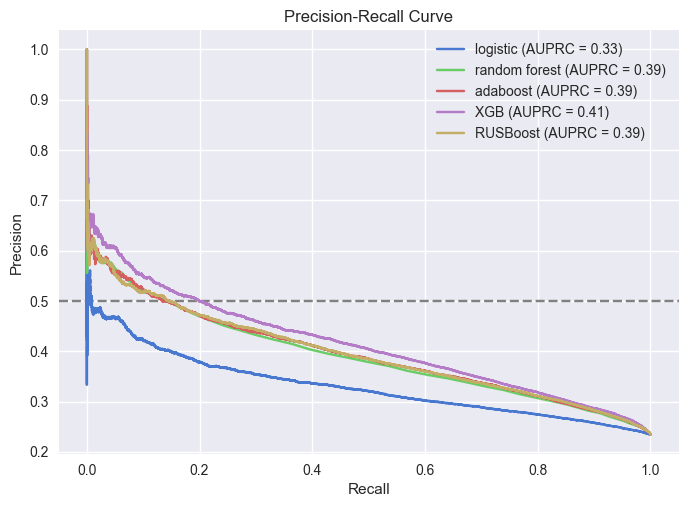

In [71]:
# Compute the FPR and TPR for each model
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute the false positive rate, true positive rate, and thresholds
precision1, recall1, _ = precision_recall_curve(Y_val, logistic_y_scores)
precision2, recall2, _ = precision_recall_curve(Y_val, rf_y_scores)
precision3, recall3, _ = precision_recall_curve(Y_val, adaboost_y_scores)
precision4, recall4, _ = precision_recall_curve(Y_val, xgb_y_scores)
precision5, recall5, _ = precision_recall_curve(Y_val, rusboost_y_scores)

# Compute the AUC for each model
auc_model1 = auc(recall1, precision1)
auc_model2 = auc(recall2, precision2)
auc_model3 = auc(recall3, precision3)
auc_model4 = auc(recall4, precision4)
auc_model5 = auc(recall5, precision5)

# Plot the ROC curves
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall1, precision1, label='logistic (AUPRC = {:.2f})'.format(auc_model1))
plt.plot(recall2, precision2, label='random forest (AUPRC = {:.2f})'.format(auc_model2))
plt.plot(recall3, precision3, label='adaboost (AUPRC = {:.2f})'.format(auc_model3))
plt.plot(recall4, precision4, label='XGB (AUPRC = {:.2f})'.format(auc_model4))
plt.plot(recall5, precision5, label='RUSBoost (AUPRC = {:.2f})'.format(auc_model5))

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# With SMOTE

## SMOTE

In [72]:
# Uncomment the below code to fit SMOTE
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(categorical_features=range(len(num_cols), X_train.shape[1]), sampling_strategy='auto', k_neighbors = 3)
# X_tr, Y_tr = sm.fit_resample(X_train, Y_tr)

## Data Import

In [73]:
train_df = pd.read_csv(r".\Dataset\SmoteNC\SmoteNC_X.csv", low_memory = False)
X_validate = pd.read_csv(r".\Dataset\SmoteNC\X_val.csv", low_memory = False)
Y_val = pd.read_csv(r".\Dataset\SmoteNC\Y_val.csv", low_memory = False)
test_df = pd.read_csv(r".\Dataset\FinalData\test_data.csv", low_memory = False)

In [74]:
train_df = train_df.astype({"verification_status":"category", \
                "loan_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category"})

X_validate = X_validate.astype({"verification_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category"})

test_df = test_df.astype({"verification_status":"category", \
                "loan_status":"category", \
                "purpose":"category", \
                "addr_state":"category", \
                "emp_length":"category", \
                "home_ownership":"category", \
                "earliest_cr_line":"datetime64[ns]", \
                "issue_d":"datetime64[ns]", \
                "last_credit_pull_d":"datetime64[ns]"})

In [75]:
train_df = train_df.astype({"emp_length":"object"})
train_df["emp_length"].fillna("NA", inplace=True)
train_df = train_df.astype({"emp_length":"category"})

X_validate = X_validate.astype({"emp_length":"object"})
X_validate["emp_length"].fillna("NA", inplace=True)
X_validate = X_validate.astype({"emp_length":"category"})

test_df = test_df.astype({"emp_length":"object"})
test_df["emp_length"].fillna("NA", inplace=True)
test_df = test_df.astype({"emp_length":"category"})

In [76]:
num_cols = list(train_df.select_dtypes(include=["int64", "float64"]).columns)

cat_cols = list(train_df.select_dtypes(include=["category"]).columns)
cat_cols.remove("loan_status")

X_train = train_df[num_cols + cat_cols]
Y_tr = train_df["loan_status"]

default_value = None
encoding_dict = dict.fromkeys(cat_cols, default_value)

X_tr = X_train[num_cols].to_numpy()
X_val = X_validate[num_cols].to_numpy()

for key, value in encoding_dict.items():
    if value == None:
        encoding_dict[key] = LabelBinarizer()
        encoding_dict[key].fit(X_train[key].values.reshape(-1, 1))
        X_tr = np.concatenate((X_tr, encoding_dict[key].transform(X_train[key].values.reshape(-1, 1))), axis = 1)
        X_val = np.concatenate((X_val, encoding_dict[key].transform(X_validate[key].values.reshape(-1, 1))), axis=1)

In [77]:
feature_names = []
for k, v in encoding_dict.items():
    feature_names.extend(v.classes_)

## Modelling

### Logistic Regression

In [78]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

In [79]:
from sklearn.linear_model import LogisticRegression

logisticRegr_smote = LogisticRegression(verbose=1)
logisticRegr_smote.fit(X_tr, Y_tr)

y_pred_smote = logisticRegr_smote.predict(X_val)
accuray = accuracy_score(Y_val, y_pred_smote)    
f1 = f1_score(Y_val, y_pred_smote, average="weighted")

precision = precision_score(Y_val, y_pred_smote, average="weighted")
recall = recall_score(Y_val, y_pred_smote, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.594985088455859
F1 Score: 0.6256958011009384
Precision: 0.7104434306026236
Recall: 0.594985088455859


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished


In [80]:
logisticRegr_smote_test = LogisticRegression(verbose=1, C=0.1, solver = 'sag', max_iter = 3000)
logisticRegr_smote_test.fit(X_tr, Y_tr)

y_pred_smote_test = logisticRegr_smote_test.predict(X_val)
accuray = accuracy_score(Y_val, y_pred_smote_test)    
f1 = f1_score(Y_val, y_pred_smote_test, average="weighted")

precision = precision_score(Y_val, y_pred_smote_test, average="weighted")
recall = recall_score(Y_val, y_pred_smote_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1701 seconds
Accuracy: 0.594405999363002
F1 Score: 0.6251810761405286
Precision: 0.7105727477539591
Recall: 0.594405999363002


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.4min finished


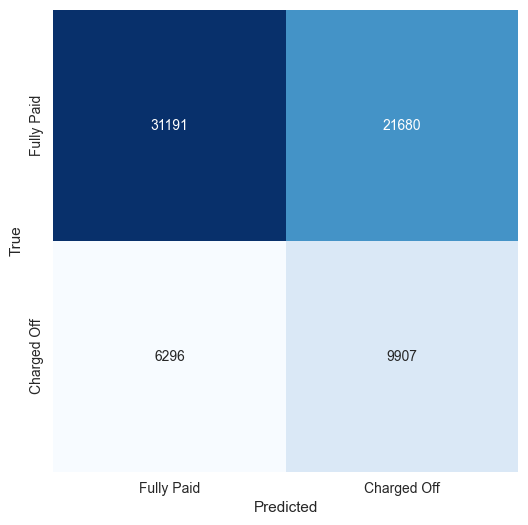

In [81]:
cm = confusion_matrix(Y_val, y_pred_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

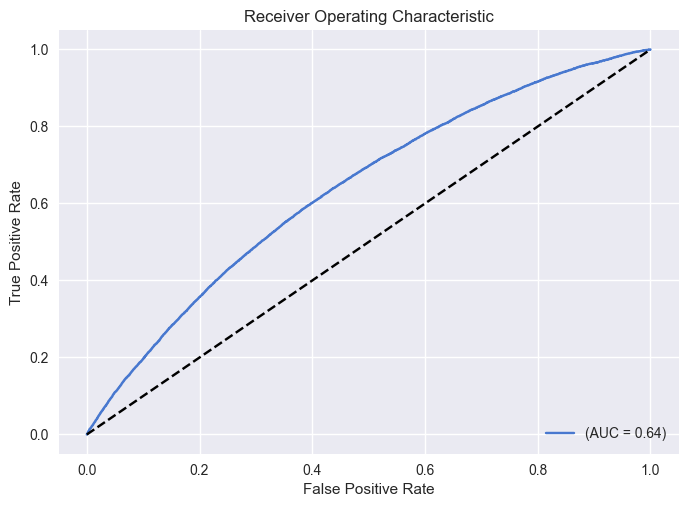

In [82]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

logistic_y_scores = logisticRegr_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, logistic_y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

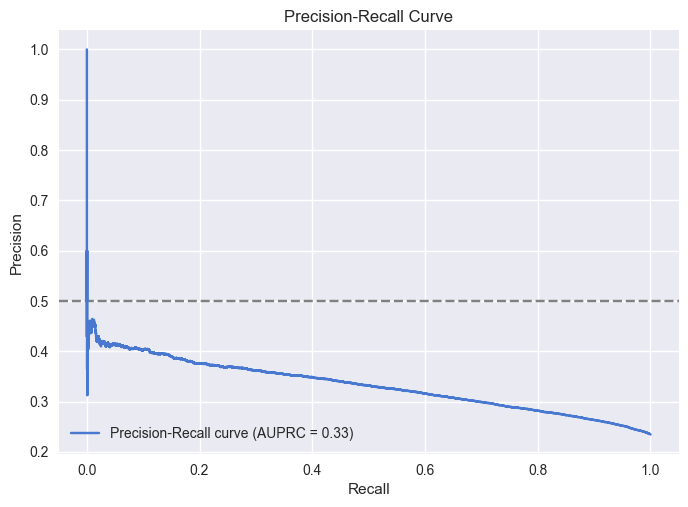

AUPRC: 0.3315596989198302


In [83]:
from sklearn.metrics import precision_recall_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, logistic_y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### Decision Tree

In [84]:
decisionTree_smote = DecisionTreeClassifier()
decisionTree_smote.fit(X_tr, Y_tr)
decisionTree_pred_smote = decisionTree_smote.predict(X_val)

In [85]:
accuracy = accuracy_score(Y_val, decisionTree_pred_smote)    
f1 = f1_score(Y_val, decisionTree_pred_smote, average="weighted")

precision = precision_score(Y_val, decisionTree_pred_smote, average="weighted")
recall = recall_score(Y_val, decisionTree_pred_smote, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9324492573182384
F1 Score: 0.9326699861998691
Precision: 0.9329394822452683
Recall: 0.9324492573182384


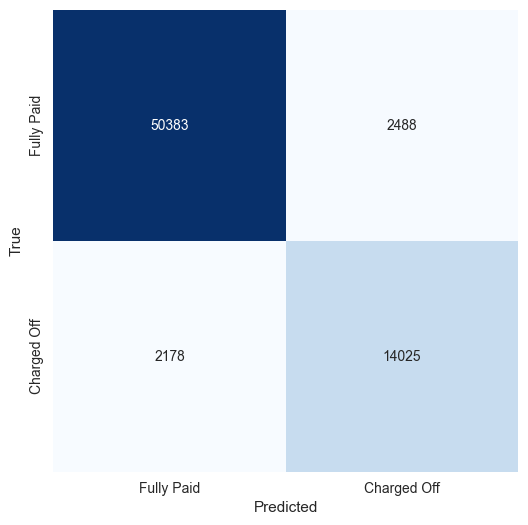

In [86]:
cm = confusion_matrix(Y_val, decisionTree_pred_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid","Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

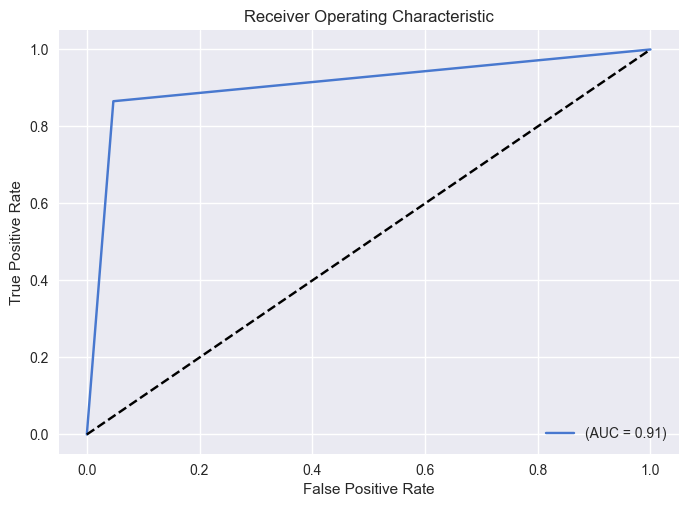

In [87]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = decisionTree_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

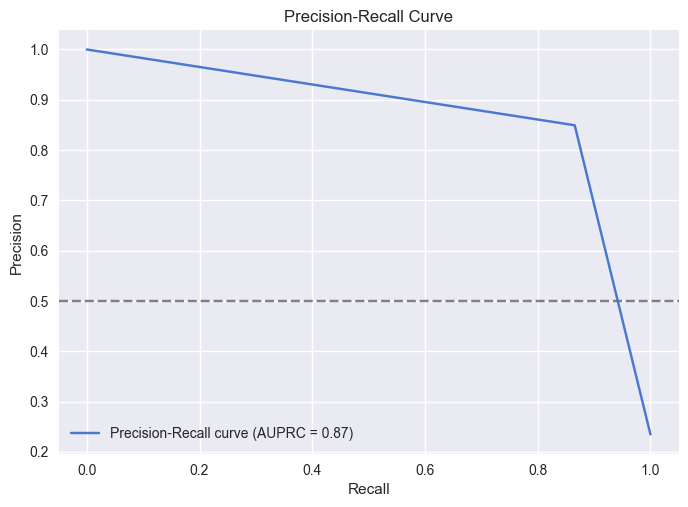

AUPRC: 0.8732213397130919


In [88]:
from sklearn.metrics import precision_recall_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf_smote = RandomForestClassifier(verbose=True)
rf_smote.fit(X_tr, Y_tr)
y_pred_rf_smote = rf_smote.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


In [90]:
accuracy = accuracy_score(Y_val, y_pred_rf_smote)    
f1 = f1_score(Y_val, y_pred_rf_smote, average="weighted")
precision = precision_score(Y_val, y_pred_rf_smote, average="weighted")
recall = recall_score(Y_val, y_pred_rf_smote, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9517763557923387
F1 Score: 0.9501978460843338
Precision: 0.9529437306289419
Recall: 0.9517763557923387


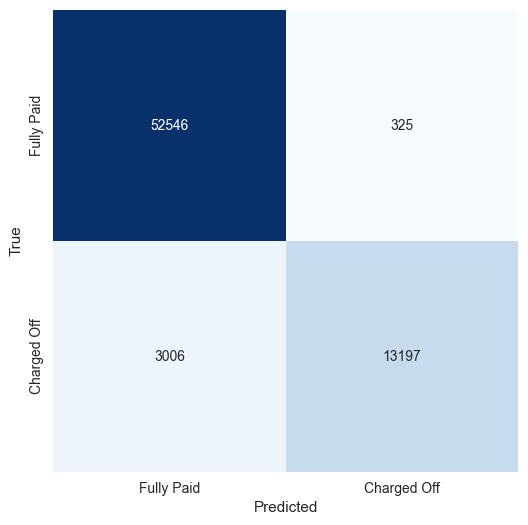

In [91]:
cm = confusion_matrix(Y_val, y_pred_rf_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


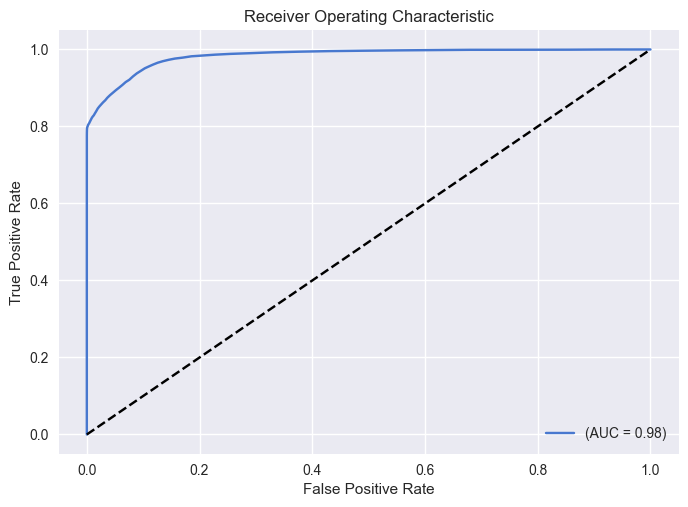

In [92]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rf_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

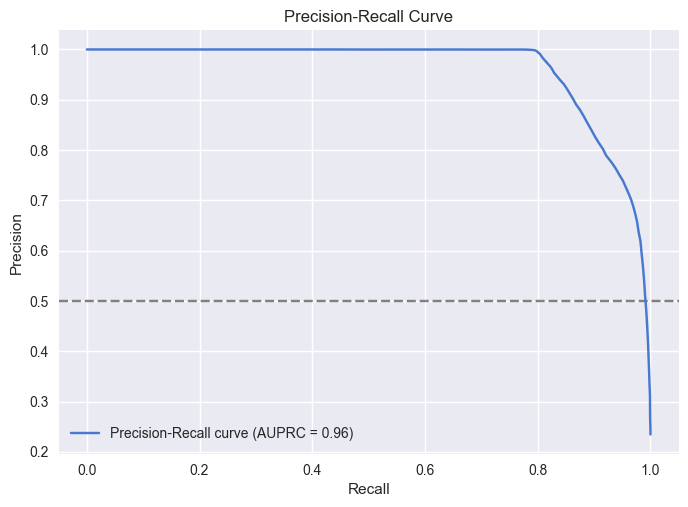

AUPRC: 0.9620927470851167


In [93]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### AdaBoost

In [94]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_smote = AdaBoostClassifier()
adaboost_smote.fit(X_tr, Y_tr)

AdaBoostClassifier()

In [95]:
adaboost_pred_smote = adaboost_smote.predict(X_val)
accuray = accuracy_score(Y_val, adaboost_pred_smote)    
f1 = f1_score(Y_val, adaboost_pred_smote, average="weighted")
precision = precision_score(Y_val, adaboost_pred_smote, average="weighted")
recall = recall_score(Y_val, adaboost_pred_smote, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.722457075020992
F1 Score: 0.7066442685503928
Precision: 0.6963418831390344
Recall: 0.722457075020992


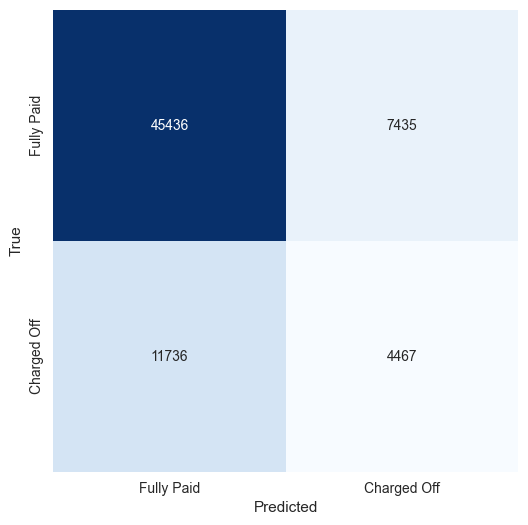

In [96]:
cm = confusion_matrix(Y_val, adaboost_pred_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

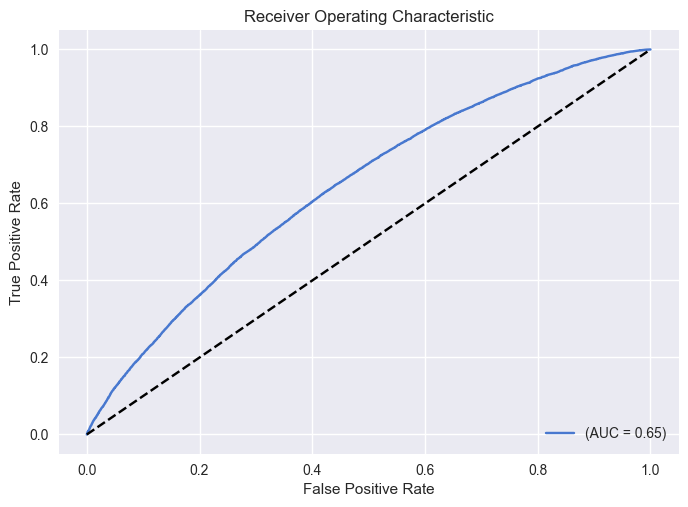

In [97]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = adaboost_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

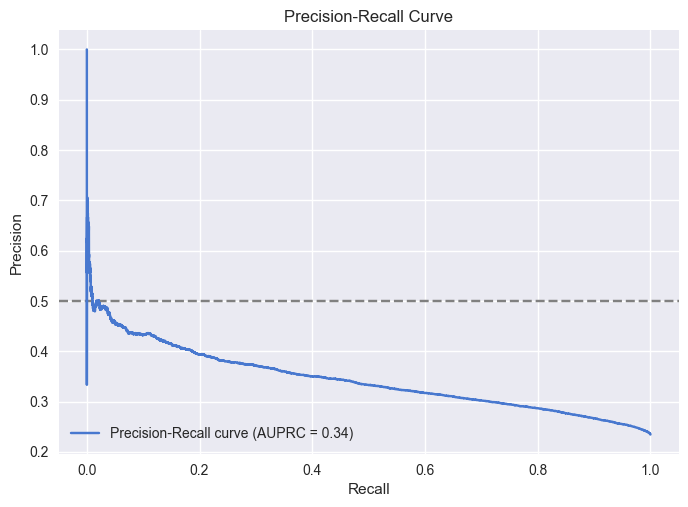

AUPRC: 0.3430378674498966


In [98]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### XGBoost

In [99]:
import xgboost as xgb
xgb_classifier_smote = xgb.XGBClassifier()

# Train the model
xgb_classifier_smote.fit(X_tr, Y_tr)
xgb_pred_smote = xgb_classifier_smote.predict(X_val)

In [100]:
accuray = accuracy_score(Y_val, xgb_pred_smote)    
f1 = f1_score(Y_val, xgb_pred_smote, average="weighted")
precision = precision_score(Y_val, xgb_pred_smote, average="weighted")
recall = recall_score(Y_val, xgb_pred_smote, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7817413209022208
F1 Score: 0.7266206767370335
Precision: 0.755639179002241
Recall: 0.7817413209022208


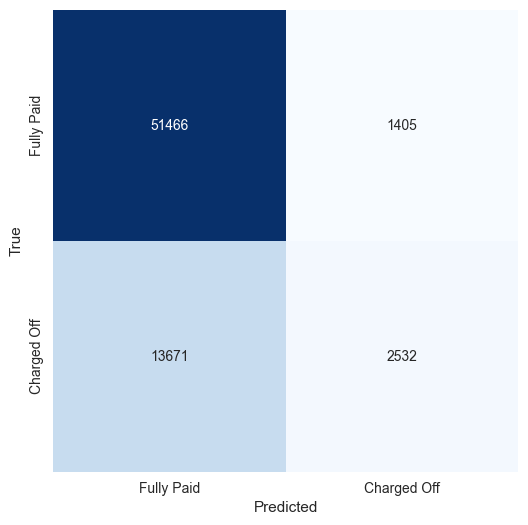

In [101]:
cm = confusion_matrix(Y_val, xgb_pred_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

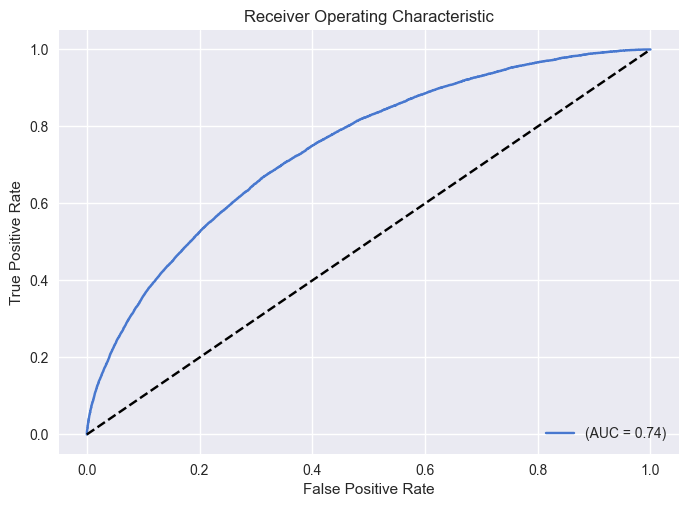

In [102]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = xgb_classifier_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

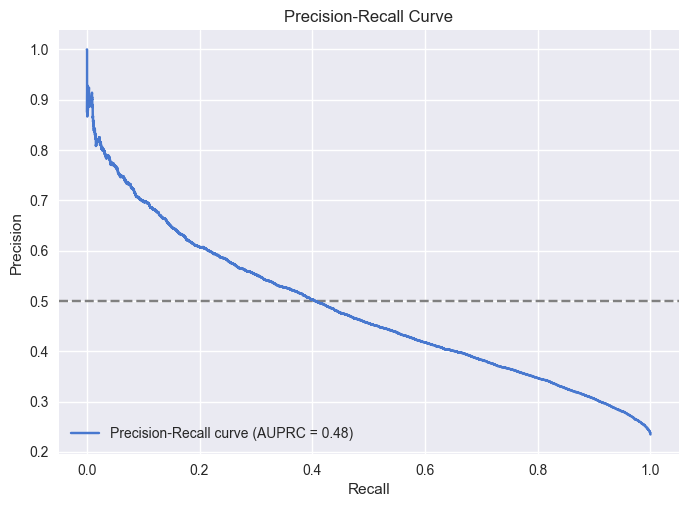

AUPRC: 0.48189674575801644


In [103]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### RUSBoost

In [104]:
from imblearn.ensemble import RUSBoostClassifier

rusboost_smote = RUSBoostClassifier()
rusboost_smote.fit(X_tr, Y_tr)
rusboost_pred_smote = rusboost_smote.predict(X_val)

In [105]:
accuray = accuracy_score(Y_val, rusboost_pred_smote)    
f1 = f1_score(Y_val, rusboost_pred_smote, average="weighted")
precision = precision_score(Y_val, rusboost_pred_smote, average="weighted")
recall = recall_score(Y_val, rusboost_pred_smote, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.722457075020992
F1 Score: 0.7066442685503928
Precision: 0.6963418831390344
Recall: 0.722457075020992


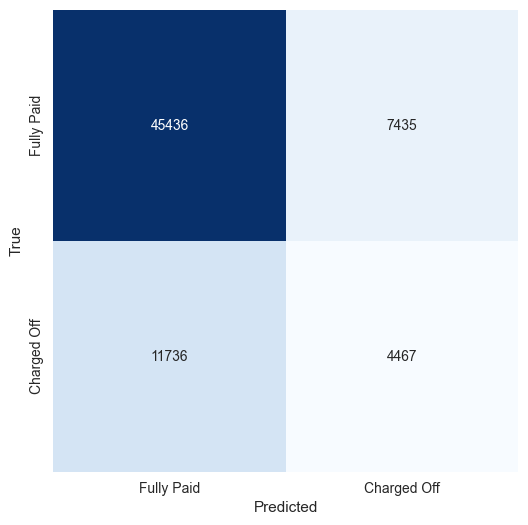

In [106]:
cm = confusion_matrix(Y_val, rusboost_pred_smote)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

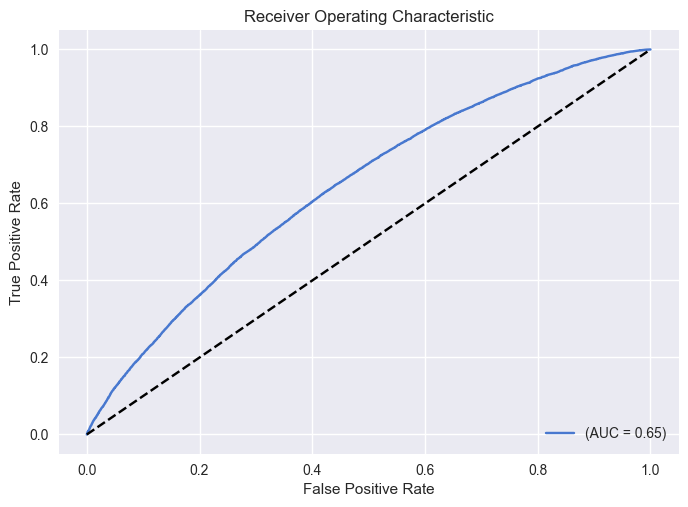

In [107]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rusboost_smote.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

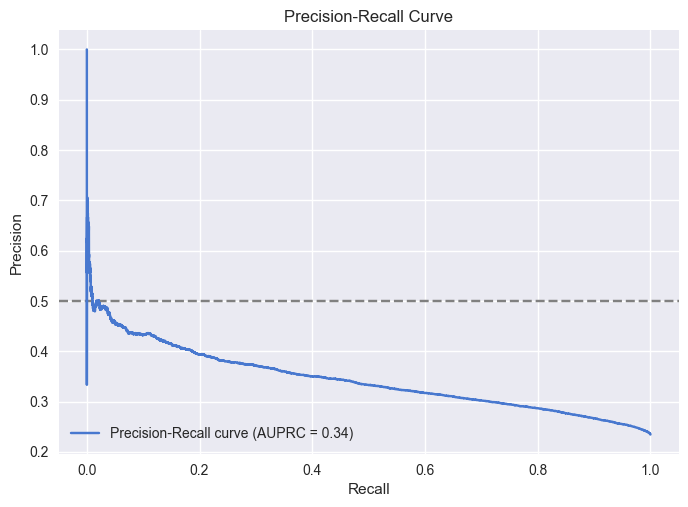

AUPRC: 0.3430378674498966


In [108]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


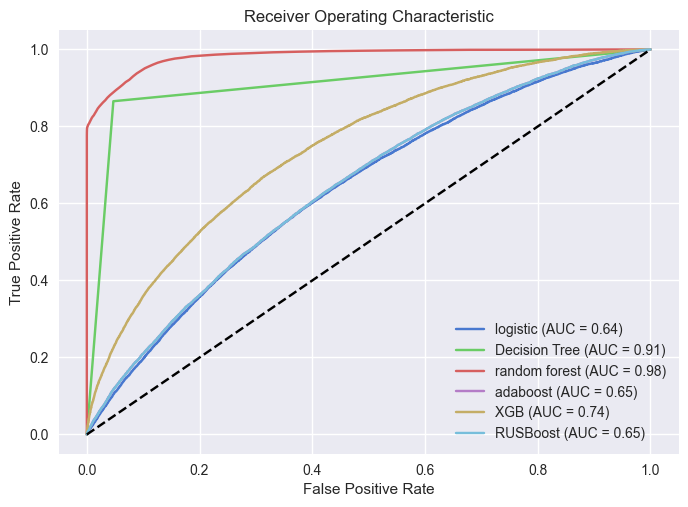

In [109]:
# Compute the FPR and TPR for each model
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

logistic_smote_y_scores = logisticRegr_smote.predict_proba(X_val)[:, 1]
decisionTree_smote_y_scores = decisionTree_smote.predict_proba(X_val)[:, 1]
rf_smote_y_scores = rf_smote.predict_proba(X_val)[:, 1]
adaboost_smote_y_scores = adaboost_smote.predict_proba(X_val)[:, 1]
xgb_smote_y_scores = xgb_classifier_smote.predict_proba(X_val)[:, 1]
rusboost_smote_y_scores = rusboost_smote.predict_proba(X_val)[:, 1]


# Compute the false positive rate, true positive rate, and thresholds
fpr_model1, tpr_model1, _ = roc_curve(Y_val, logistic_smote_y_scores)
fpr_model2, tpr_model2, _ = roc_curve(Y_val, rf_smote_y_scores)
fpr_model3, tpr_model3, _ = roc_curve(Y_val, adaboost_smote_y_scores)
fpr_model4, tpr_model4, _ = roc_curve(Y_val, xgb_smote_y_scores)
fpr_model5, tpr_model5, _ = roc_curve(Y_val, rusboost_smote_y_scores)
fpr_model6, tpr_model6, _ = roc_curve(Y_val, decisionTree_smote_y_scores)

# Compute the AUC for each model
auc_model1 = auc(fpr_model1, tpr_model1)
auc_model2 = auc(fpr_model2, tpr_model2)
auc_model3 = auc(fpr_model3, tpr_model3)
auc_model4 = auc(fpr_model4, tpr_model4)
auc_model5 = auc(fpr_model5, tpr_model5)
auc_model6 = auc(fpr_model6, tpr_model6)

# Plot the ROC curves
plt.plot(fpr_model1, tpr_model1, label='logistic (AUC = {:.2f})'.format(auc_model1))
plt.plot(fpr_model6, tpr_model6, label='Decision Tree (AUC = {:.2f})'.format(auc_model6))
plt.plot(fpr_model2, tpr_model2, label='random forest (AUC = {:.2f})'.format(auc_model2))
plt.plot(fpr_model3, tpr_model3, label='adaboost (AUC = {:.2f})'.format(auc_model3))
plt.plot(fpr_model4, tpr_model4, label='XGB (AUC = {:.2f})'.format(auc_model4))
plt.plot(fpr_model5, tpr_model5, label='RUSBoost (AUC = {:.2f})'.format(auc_model5))

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()


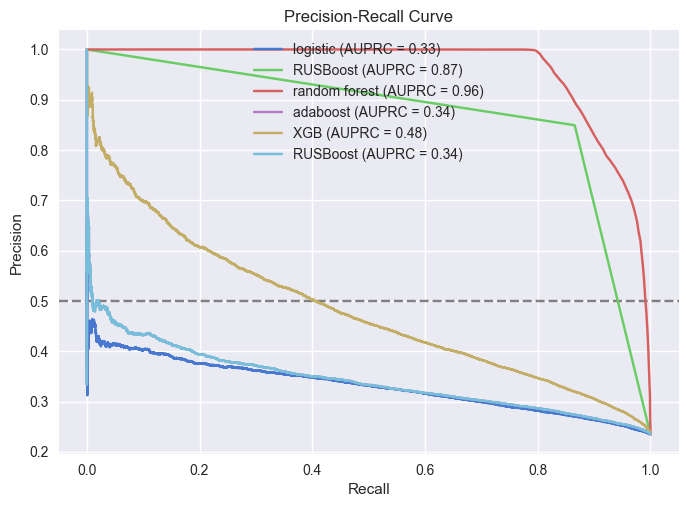

In [110]:
# Compute the FPR and TPR for each model
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute the false positive rate, true positive rate, and thresholds
precision1, recall1, _ = precision_recall_curve(Y_val, logistic_smote_y_scores)
precision2, recall2, _ = precision_recall_curve(Y_val, rf_smote_y_scores)
precision3, recall3, _ = precision_recall_curve(Y_val, adaboost_smote_y_scores)
precision4, recall4, _ = precision_recall_curve(Y_val, xgb_smote_y_scores)
precision5, recall5, _ = precision_recall_curve(Y_val, rusboost_smote_y_scores)
precision6, recall6, _ = precision_recall_curve(Y_val, decisionTree_smote_y_scores)

# Compute the AUC for each model
auc_model1 = auc(recall1, precision1)
auc_model2 = auc(recall2, precision2)
auc_model3 = auc(recall3, precision3)
auc_model4 = auc(recall4, precision4)
auc_model5 = auc(recall5, precision5)
auc_model6 = auc(recall6, precision6)

# Plot the ROC curves
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall1, precision1, label='logistic (AUPRC = {:.2f})'.format(auc_model1))
plt.plot(recall6, precision6, label='RUSBoost (AUPRC = {:.2f})'.format(auc_model6))
plt.plot(recall2, precision2, label='random forest (AUPRC = {:.2f})'.format(auc_model2))
plt.plot(recall3, precision3, label='adaboost (AUPRC = {:.2f})'.format(auc_model3))
plt.plot(recall4, precision4, label='XGB (AUPRC = {:.2f})'.format(auc_model4))
plt.plot(recall5, precision5, label='RUSBoost (AUPRC = {:.2f})'.format(auc_model5))

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# Show the plot
plt.show()


# With SMOTE Tomek

## SMOTE Tomek

In [111]:
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_tr, Y_tr = smote_tomek.fit_resample(X_tr, Y_tr)

In [112]:
pd.DataFrame(Y_tr).value_counts()

loan_status
1              211479
0              209417
Name: count, dtype: int64

## Modelling

### Logistic Regression

In [113]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

In [114]:
from sklearn.linear_model import LogisticRegression

logisticRegr_smote_tomek = LogisticRegression(verbose=1, max_iter=3000)
logisticRegr_smote_tomek.fit(X_tr, Y_tr)

y_pred_smote_tomek = logisticRegr_smote_tomek.predict(X_val)
accuray = accuracy_score(Y_val, y_pred_smote_tomek)    
f1 = f1_score(Y_val, y_pred_smote_tomek, average="weighted")

precision = precision_score(Y_val, y_pred_smote_tomek, average="weighted")
recall = recall_score(Y_val, y_pred_smote_tomek, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.5844890986478269
F1 Score: 0.6161432434952997
Precision: 0.7176866281210691
Recall: 0.5844890986478269


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


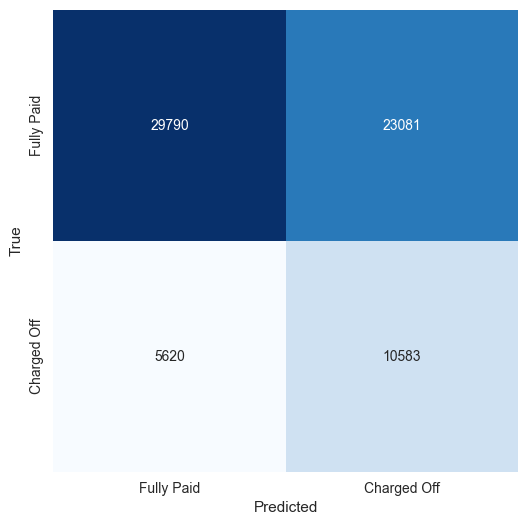

In [115]:
cm = confusion_matrix(Y_val, y_pred_smote_tomek)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

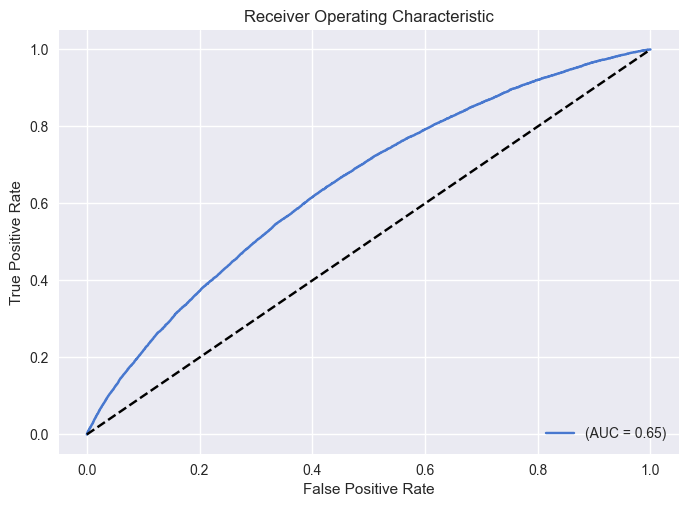

In [116]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

logistic_y_scores = logisticRegr_smote_tomek.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, logistic_y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

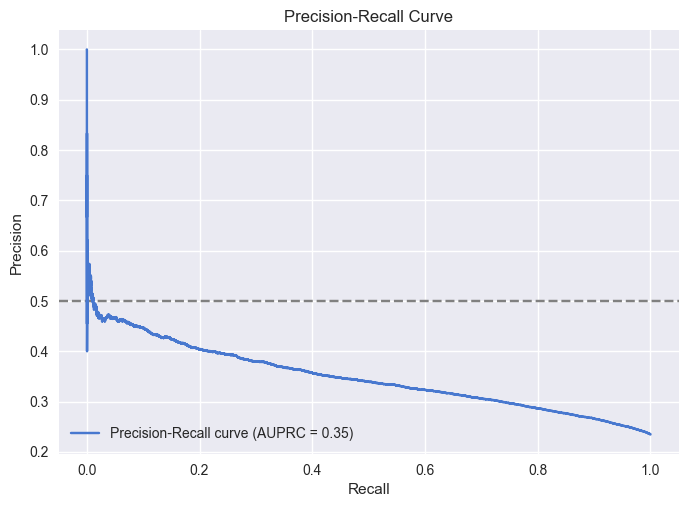

AUPRC: 0.34745602612134197


In [117]:
from sklearn.metrics import precision_recall_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, logistic_y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### Decision Tree

In [118]:
decisionTree_smote_tomek = DecisionTreeClassifier()
decisionTree_smote_tomek.fit(X_tr, Y_tr)
decisionTree_pred_smote_tomek = decisionTree_smote_tomek.predict(X_val)

In [119]:
accuracy = accuracy_score(Y_val, decisionTree_pred_smote_tomek)    
f1 = f1_score(Y_val, decisionTree_pred_smote_tomek, average="weighted")

precision = precision_score(Y_val, decisionTree_pred_smote_tomek, average="weighted")
recall = recall_score(Y_val, decisionTree_pred_smote_tomek, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9284390653502042
F1 Score: 0.92876519924851
Precision: 0.9291861630693699
Recall: 0.9284390653502042


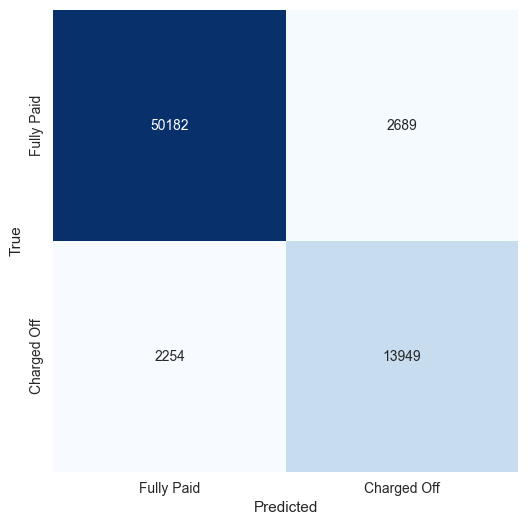

In [120]:
cm = confusion_matrix(Y_val, decisionTree_pred_smote_tomek)
plt.figure(figsize = (6,6))
labels = ["Fully Paid","Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

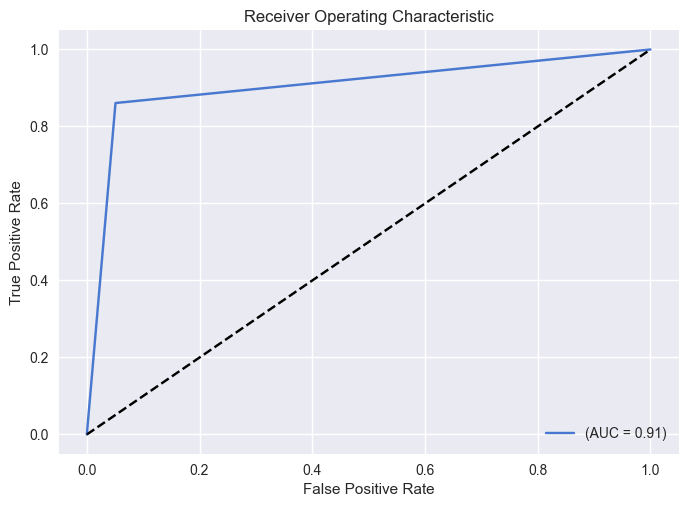

In [121]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = decisionTree_smote_tomek.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

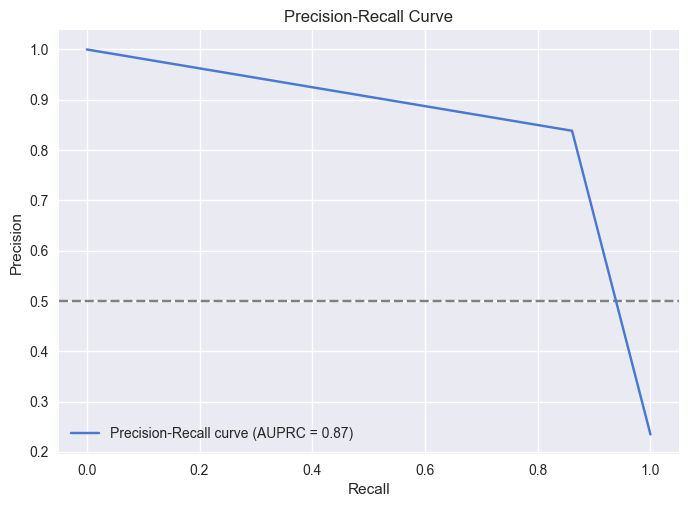

AUPRC: 0.8659518230507403


In [122]:
from sklearn.metrics import precision_recall_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

rf_smote_tomek = RandomForestClassifier(verbose=True)
rf_smote_tomek.fit(X_tr, Y_tr)
y_pred_rf_smote_tomek = rf_smote_tomek.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


In [124]:
accuracy = accuracy_score(Y_val, y_pred_rf_smote_tomek)    
f1 = f1_score(Y_val, y_pred_rf_smote_tomek, average="weighted")
precision = precision_score(Y_val, y_pred_rf_smote_tomek, average="weighted")
recall = recall_score(Y_val, y_pred_rf_smote_tomek, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9513130845180531
F1 Score: 0.9497583860985499
Precision: 0.9523265211535866
Recall: 0.9513130845180531


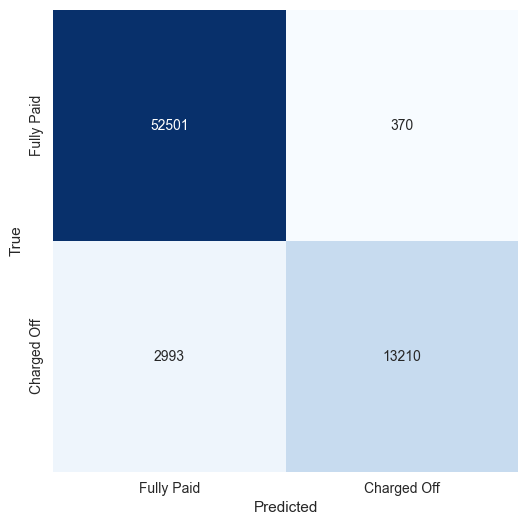

In [125]:
cm = confusion_matrix(Y_val, y_pred_rf_smote_tomek)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


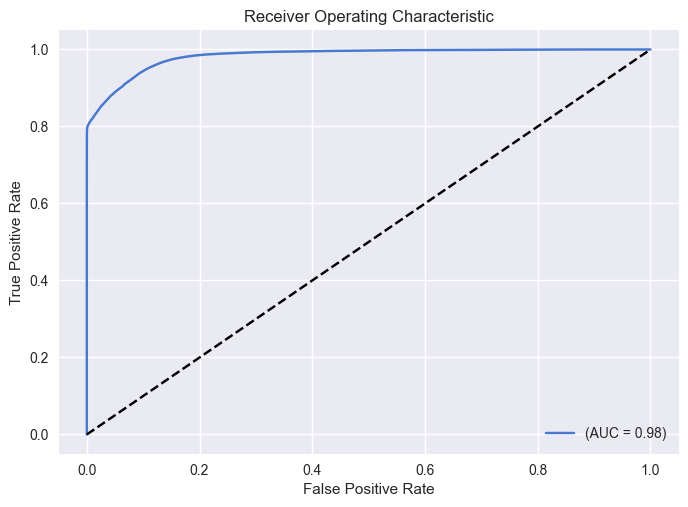

In [126]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rf_smote_tomek.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

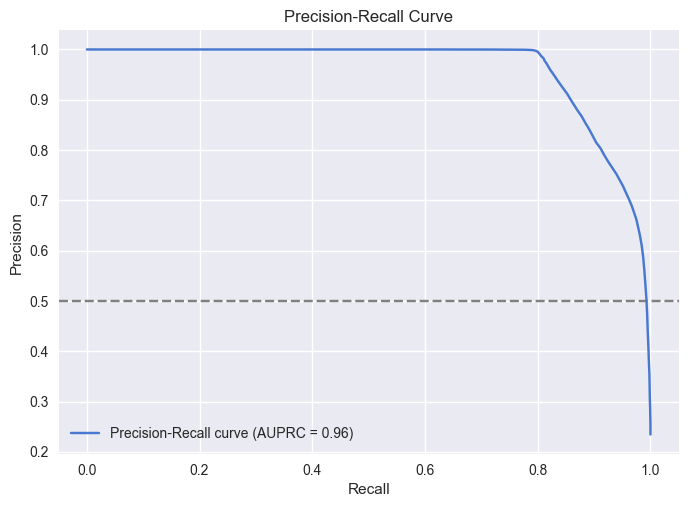

AUPRC: 0.9612079277201242


In [127]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### AdaBoost

In [128]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_smote_tomek = AdaBoostClassifier()
adaboost_smote_tomek.fit(X_tr, Y_tr)

AdaBoostClassifier()

In [129]:
adaboost_pred_smote_tomek = adaboost_smote_tomek.predict(X_val)
accuray = accuracy_score(Y_val, adaboost_pred_smote_tomek)    
f1 = f1_score(Y_val, adaboost_pred_smote_tomek, average="weighted")
precision = precision_score(Y_val, adaboost_pred_smote_tomek, average="weighted")
recall = recall_score(Y_val, adaboost_pred_smote_tomek, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7224281205663491
F1 Score: 0.7088106403907617
Precision: 0.699491494434727
Recall: 0.7224281205663491


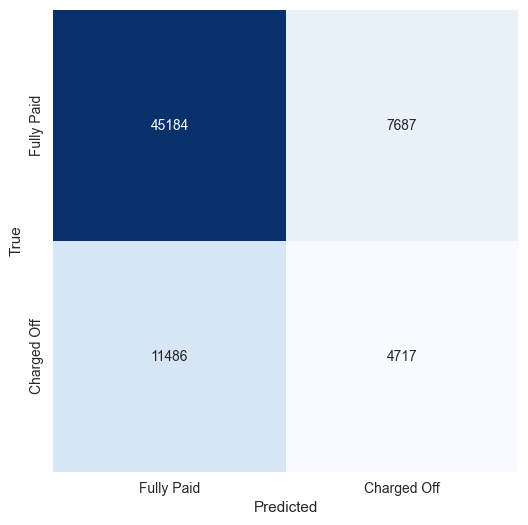

In [130]:
cm = confusion_matrix(Y_val, adaboost_pred_smote_tomek)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

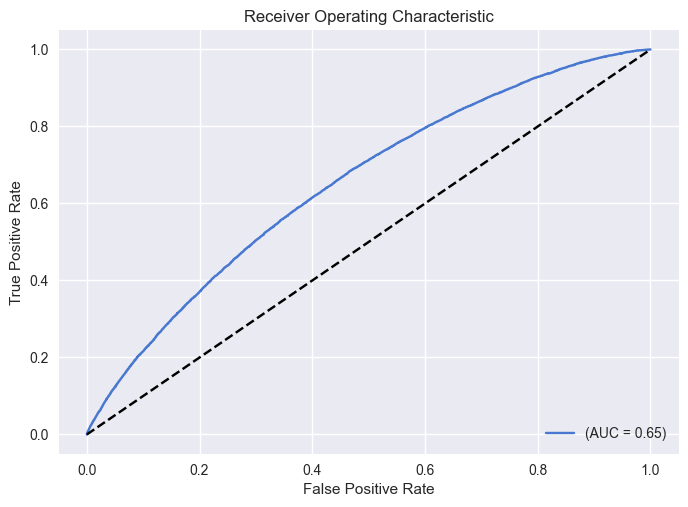

In [131]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = adaboost_smote_tomek.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

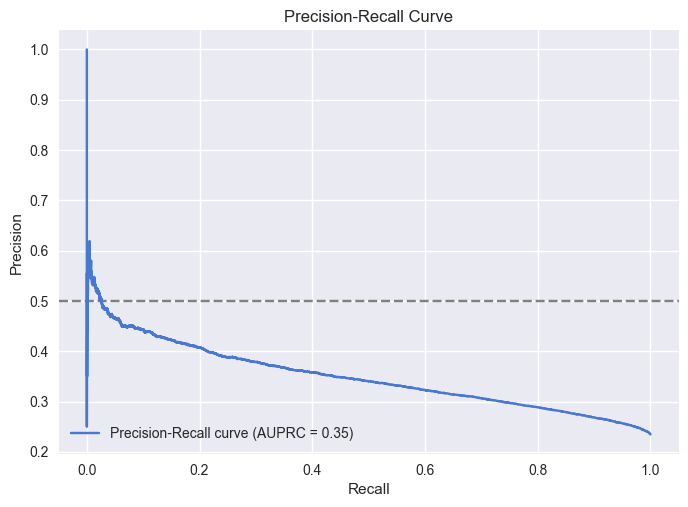

AUPRC: 0.34864678029438334


In [132]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### XGBoost

In [133]:
import xgboost as xgb
xgb_classifier_smote_tomek = xgb.XGBClassifier()

# Train the model
xgb_classifier_smote_tomek.fit(X_tr, Y_tr)
xgb_pred_smote_tomek = xgb_classifier_smote_tomek.predict(X_val)

In [134]:
accuray = accuracy_score(Y_val, xgb_pred_smote_tomek)    
f1 = f1_score(Y_val, xgb_pred_smote_tomek, average="weighted")
precision = precision_score(Y_val, xgb_pred_smote_tomek, average="weighted")
recall = recall_score(Y_val, xgb_pred_smote_tomek, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7815965486290066
F1 Score: 0.7269271590702261
Precision: 0.7549781133302315
Recall: 0.7815965486290066


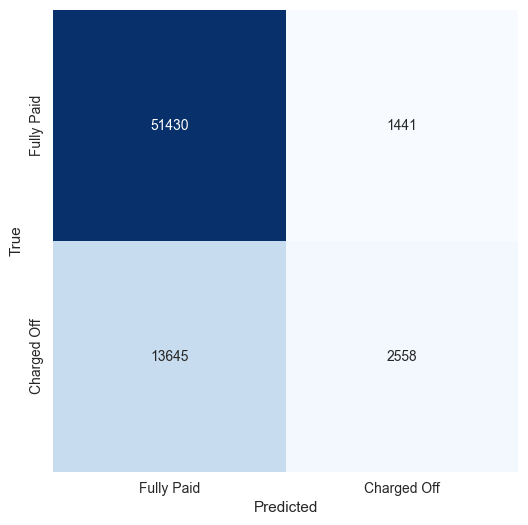

In [135]:
cm = confusion_matrix(Y_val, xgb_pred_smote_tomek)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off", ]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

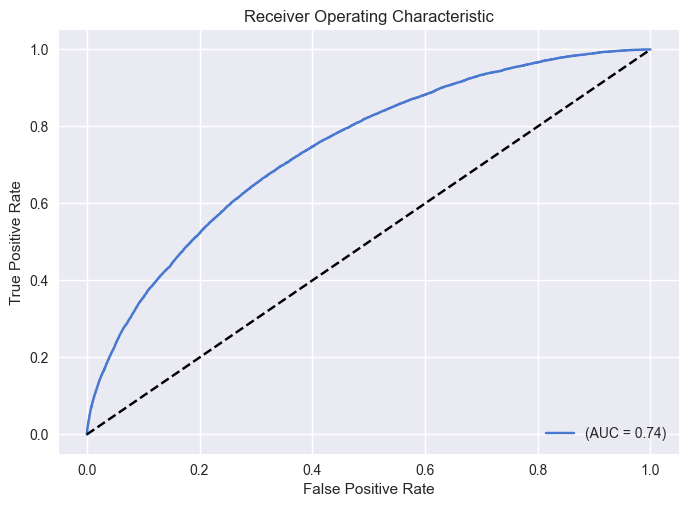

In [136]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = xgb_classifier_smote_tomek.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

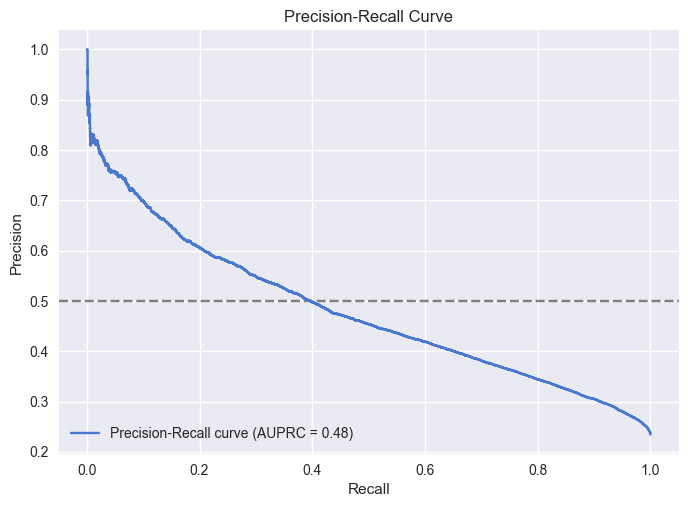

AUPRC: 0.479104990710326


In [137]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

### RUSBoost

In [138]:
from imblearn.ensemble import RUSBoostClassifier

rusboost_smote_tomek = RUSBoostClassifier()
rusboost_smote_tomek.fit(X_tr, Y_tr)
rusboost_pred_smote_tomek = rusboost_smote_tomek.predict(X_val)

In [139]:
accuray = accuracy_score(Y_val, rusboost_pred_smote_tomek)    
f1 = f1_score(Y_val, rusboost_pred_smote_tomek, average="weighted")
precision = precision_score(Y_val, rusboost_pred_smote_tomek, average="weighted")
recall = recall_score(Y_val, rusboost_pred_smote_tomek, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7218924631554565
F1 Score: 0.7074845582008134
Precision: 0.6977723595106747
Recall: 0.7218924631554565


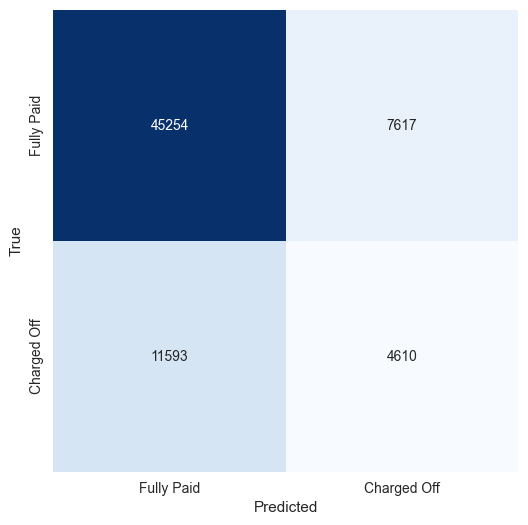

In [140]:
cm = confusion_matrix(Y_val, rusboost_pred_smote_tomek)
plt.figure(figsize = (6,6))
labels = ["Fully Paid", "Charged Off"]
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar=False, fmt='g', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

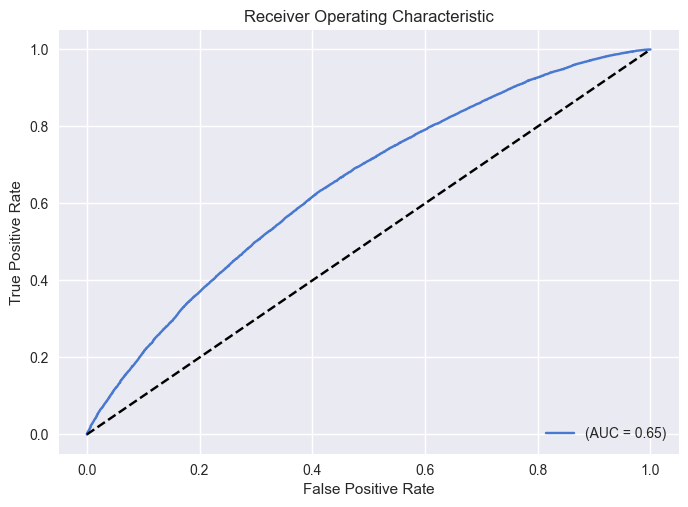

In [141]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

y_scores = rusboost_smote_tomek.predict_proba(X_val)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_val, y_scores)

auc_model = auc(fpr, tpr)

# Plot the ROC curves
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_model))

# Plot the ROC curve  label='logistic (AUC = {:.2f})'.format(auc_model1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

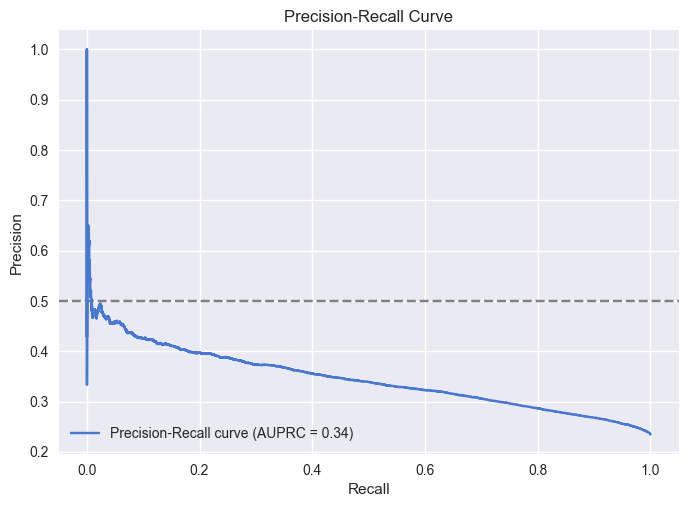

AUPRC: 0.344734980274356


In [142]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_val, y_scores)
plt.style.use('seaborn-v0_8-muted')

# Compute the AUPRC
auprc = auc(recall, precision)

# Plot the precision-recall curve
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = {:.2f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUPRC
print("AUPRC:", auprc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


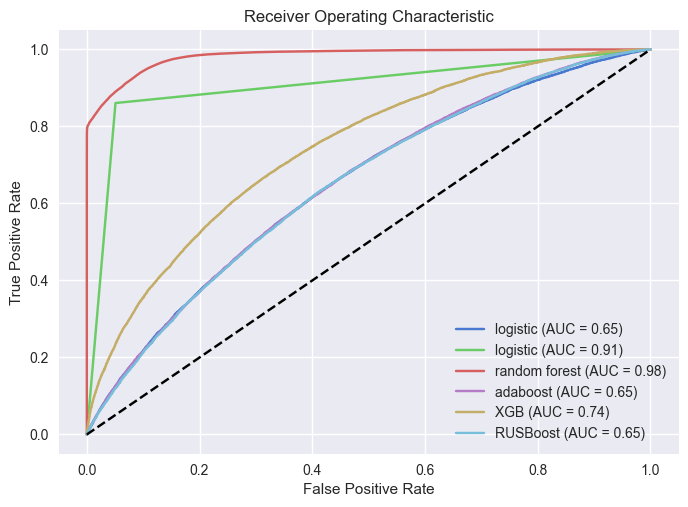

In [143]:
# Compute the FPR and TPR for each model
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

logistic_smote_tomek_y_scores = logisticRegr_smote_tomek.predict_proba(X_val)[:, 1]
decisionTree_smote_tomek_y_scores = decisionTree_smote_tomek.predict_proba(X_val)[:, 1]
rf_smote_tomek_y_scores = rf_smote_tomek.predict_proba(X_val)[:, 1]
adaboost_smote_tomek_y_scores = adaboost_smote_tomek.predict_proba(X_val)[:, 1]
xgb_smote_tomek_y_scores = xgb_classifier_smote_tomek.predict_proba(X_val)[:, 1]
rusboost_smote_tomek_y_scores = rusboost_smote_tomek.predict_proba(X_val)[:, 1]


# Compute the false positive rate, true positive rate, and thresholds
fpr_model1, tpr_model1, _ = roc_curve(Y_val, logistic_smote_tomek_y_scores)
fpr_model2, tpr_model2, _ = roc_curve(Y_val, rf_smote_tomek_y_scores)
fpr_model3, tpr_model3, _ = roc_curve(Y_val, adaboost_smote_tomek_y_scores)
fpr_model4, tpr_model4, _ = roc_curve(Y_val, xgb_smote_tomek_y_scores)
fpr_model5, tpr_model5, _ = roc_curve(Y_val, rusboost_smote_tomek_y_scores)
fpr_model6, tpr_model6, _ = roc_curve(Y_val, decisionTree_smote_tomek_y_scores)

# Compute the AUC for each model
auc_model1 = auc(fpr_model1, tpr_model1)
auc_model2 = auc(fpr_model2, tpr_model2)
auc_model3 = auc(fpr_model3, tpr_model3)
auc_model4 = auc(fpr_model4, tpr_model4)
auc_model5 = auc(fpr_model5, tpr_model5)
auc_model6 = auc(fpr_model6, tpr_model6)

# Plot the ROC curves
plt.plot(fpr_model1, tpr_model1, label='logistic (AUC = {:.2f})'.format(auc_model1))
plt.plot(fpr_model6, tpr_model6, label='logistic (AUC = {:.2f})'.format(auc_model6))
plt.plot(fpr_model2, tpr_model2, label='random forest (AUC = {:.2f})'.format(auc_model2))
plt.plot(fpr_model3, tpr_model3, label='adaboost (AUC = {:.2f})'.format(auc_model3))
plt.plot(fpr_model4, tpr_model4, label='XGB (AUC = {:.2f})'.format(auc_model4))
plt.plot(fpr_model5, tpr_model5, label='RUSBoost (AUC = {:.2f})'.format(auc_model5))

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()


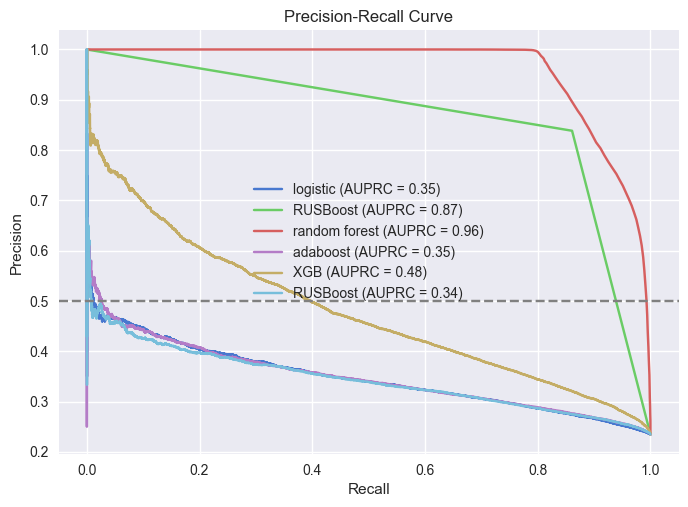

In [144]:
# Compute the FPR and TPR for each model
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-muted')

# Compute the false positive rate, true positive rate, and thresholds
precision1, recall1, _ = precision_recall_curve(Y_val, logistic_smote_tomek_y_scores)
precision2, recall2, _ = precision_recall_curve(Y_val, rf_smote_tomek_y_scores)
precision3, recall3, _ = precision_recall_curve(Y_val, adaboost_smote_tomek_y_scores)
precision4, recall4, _ = precision_recall_curve(Y_val, xgb_smote_tomek_y_scores)
precision5, recall5, _ = precision_recall_curve(Y_val, rusboost_smote_tomek_y_scores)
precision6, recall6, _ = precision_recall_curve(Y_val, decisionTree_smote_tomek_y_scores)

# Compute the AUC for each model
auc_model1 = auc(recall1, precision1)
auc_model2 = auc(recall2, precision2)
auc_model3 = auc(recall3, precision3)
auc_model4 = auc(recall4, precision4)
auc_model5 = auc(recall5, precision5)
auc_model6 = auc(recall6, precision6)

# Plot the ROC curves
plt.plot(recall1, precision1, label='logistic (AUPRC = {:.2f})'.format(auc_model1))
plt.plot(recall6, precision6, label='RUSBoost (AUPRC = {:.2f})'.format(auc_model6))
plt.plot(recall2, precision2, label='random forest (AUPRC = {:.2f})'.format(auc_model2))
plt.plot(recall3, precision3, label='adaboost (AUPRC = {:.2f})'.format(auc_model3))
plt.plot(recall4, precision4, label='XGB (AUPRC = {:.2f})'.format(auc_model4))
plt.plot(recall5, precision5, label='RUSBoost (AUPRC = {:.2f})'.format(auc_model5))

# Add labels and legend
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center')

# Show the plot
plt.show()
